# Etude et amélioration du kernel Kaggle [“**LightGBM with Simple Features**”](https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features)

Le but est de comprendre les traitements effectués par ce noyau, puis de les améliorer (fonctionnellement et techniquement).

Il y a un aller et retour entre la première partie et l'annexe :
* La première partie est d'abord le lieu du *reverse engineering* de la solution de référence et suit l'ordre fonctionnel des étapes de résolution.
* L'annexe focalise sur chaque étape clé de traitement, elle est donc plus technique.
* La première partie applique les conclusions et améliorations justifiées par l'annexe, teste la non régression fonctionnelle et compare les performances pour mettre en évidence les gains par rapport à la solution d'origine.

## Principe du `contextmanager`

In [ ]:
import time
from contextlib import contextmanager

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print(f"{title} - done in {time.time() - t0:.0f}s")

# Reprise et amélioration des fonctionnalités

## ✔ `APPLICATION`

### Chargement des tables

**Attention** Pour pouvoir comparer les résultats des deux modes de chargement, il faut avoir en tête que `get_application` effectue un `application.sort_index(inplace=True)`.

Il faut donc, en vue de comparer, réaligner les index sur ceux de la v1 : c'est le rôle de la fonction `pepper.pd_utils.align_df2_on_df1`.

Version d'origine :

In [1]:
import pandas as pd
from home_credit.old_kernel_v1 import free

def load_data_v1(nrows=None):
    # Read data and merge
    data = pd.read_csv('../../dataset/csv/application_train.csv', nrows=nrows)
    test_data = pd.read_csv('../../dataset/csv/application_test.csv', nrows=nrows)
    # print(f"Train samples: {len(df)}, test samples: {len(test_df)}")
    # NB: `append` doesn't exist in current Pandas 2.0, replaced by `concat`
    #     `append` has been deprecated since version 1.3.0 of Pandas (June 2021)
    # NB2: A reset_index() statement in older code (< 1.3.0) is equivalent to reset_index(drop=True)
    # in modern code, due to the change in the default value of the drop parameter.
    # data = data.append(test_data).reset_index()
    data = pd.concat([data, test_data], axis=0)
    data = data.reset_index(drop=True)
    free(test_data)
    return data

Nouvelle version :

Adaptation du type et des valeurs de `TARGET` pour la compatibilité de versions.

In [2]:
from home_credit.kernel import load_data
import numpy as np

def load_data_v2(nrows=None):
    data = load_data("application", nrows)
    data.TARGET = data.TARGET.astype(object).replace(-1, np.nan)
    return data

Comparaison :

In [3]:
from pepper.pd_utils import align_df2_on_df1

nrows = None  # 1_000
pk_name = "SK_ID_CURR"
data_v1 = load_data_v1(nrows)
data_v2 = align_df2_on_df1(pk_name, data_v1, load_data_v2(nrows))
# display(data_v1)
# display(data_v2)

load C:/Users/franc/Projects/pepper_credit_scoring_tool\dataset\pqt\application_train.pqt
load C:/Users/franc/Projects/pepper_credit_scoring_tool\dataset\pqt\application_test.pqt


In [4]:
from pepper.pd_utils import df_neq
is_diff = df_neq(data_v1, data_v2)
print("n_diffs:", is_diff.sum().sum())

n_diffs: 0


In [5]:
from pepper.pd_utils import check_dtypes_alignment
check_dtypes_alignment(data_v1, data_v2)

dtypes are aligned


### Nettoyage des catégories

Suppression ou correction des aberrations et valeurs manquantes pour les catégories.

In [6]:
def clean_cats_v1(data):
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    # NB > copy() was added to avoid subsequent errors or warnings caused by working on a view
    return data[data['CODE_GENDER'] != 'XNA'].copy()

In [7]:
def clean_cats_v2(data):
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    # NB > Here, there's no need for a copy, as we are working directly in-place
    data.drop(index=data.index[data.CODE_GENDER == "XNA"], inplace=True)
    # For compatibility with V1, but not necessary, it's in-place
    return data

In [8]:
clean_data_v1 = clean_cats_v1(data_v1)
clean_data_v2 = clean_cats_v2(data_v2)

In [9]:
from pepper.pd_utils import df_neq
is_diff = df_neq(clean_data_v1, clean_data_v2)
print("n_diffs:", is_diff.sum().sum())

n_diffs: 0


### Encoding des catégories binaires

In [10]:
def encode_bin_cats_v1(data):    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        # Unused `uniques` has been replaced by `_`
        data[bin_feature], _ = pd.factorize(data[bin_feature])

In [11]:
def encode_bin_cats_v2(data):    
    # Categorical features with Binary encode (0 or 1; two categories)
    bin_vars = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
    for bin_var in bin_vars:
        data[bin_var] = data[bin_var].astype("category").cat.codes

In [12]:
encode_bin_cats_v1(clean_data_v1)
encode_bin_cats_v2(clean_data_v2)

In [13]:
from pepper.pd_utils import df_neq
is_diff = df_neq(clean_data_v1, clean_data_v2)
print("n_diffs:", is_diff.sum().sum())

n_diffs: 712502


In [14]:
from pepper.pd_utils import check_dtypes_alignment
check_dtypes_alignment(clean_data_v1, clean_data_v2)

dtypes diffs:


CODE_GENDER        int64
FLAG_OWN_CAR       int64
FLAG_OWN_REALTY    int64
dtype: object

application
CODE_GENDER        int8
FLAG_OWN_CAR       int8
FLAG_OWN_REALTY    int8
dtype: object

Rien d'alarmant, les deux techniques d'encoding donnent le même résultat à une permutation des 2 labels près.

Dans tous les cas, nous n'allons pas conserver une telle approche spécifique pour les variables catégorielles binaires mais plutôt utiliser la même approche systématique de one hot encoding que pour toutes les variables catégorielles (voir `one_hot_encode_all_cats` à utiliser conjointement avec `get_categorical_vars`).

Il ne sert effectivement à rien de conserver deux colonnes c'est-à-dire deux variables anticorrélées (voir la section `drop_first` en annexe).

In [16]:
bin_vars = ["CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY"]
display(pd.concat([clean_data_v1[bin_vars], clean_data_v2[bin_vars]], axis=1).head(3))

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY
0,0,0,0,1,0,1
1,1,0,1,0,0,0
2,0,1,0,1,1,1


Pour tout faire rentrer dans l'ordre :

In [17]:
from pepper.pd_utils import df_neq
clean_data_v2.CODE_GENDER = 1 - clean_data_v2.CODE_GENDER
clean_data_v2.FLAG_OWN_REALTY = 1 - clean_data_v2.FLAG_OWN_REALTY
is_diff = df_neq(clean_data_v1, clean_data_v2)
print("n_diffs:", is_diff.sum().sum())

n_diffs: 0


In [18]:
from pepper.pd_utils import check_dtypes_alignment
check_dtypes_alignment(clean_data_v1, clean_data_v2)

dtypes diffs:


CODE_GENDER        int64
FLAG_OWN_CAR       int64
FLAG_OWN_REALTY    int64
dtype: object

application
CODE_GENDER        int8
FLAG_OWN_CAR       int8
FLAG_OWN_REALTY    int8
dtype: object

### One Hot Encoding des catégories n-binaires

In [19]:
from home_credit.old_kernel_v1 import one_hot_encoder
from home_credit.kernel import hot_encode_cats

ohe_data_v1, catvar_names_v1 = one_hot_encoder(clean_data_v1)
ohe_data_v2, catvar_names_v2 = hot_encode_cats(clean_data_v2, discard_constants=False)

In [20]:
display(ohe_data_v1.shape)
display(ohe_data_v2.shape)

(356251, 255)

(356251, 255)

La comparaison n'est pas vraiment nécessaire, mais soyons prudents :

In [21]:
display(ohe_data_v1.columns)
display(ohe_data_v2.columns)
display(ohe_data_v1.columns.difference(ohe_data_v2.columns))

Index(['SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'WALLSMATERIAL_MODE_Mixed', 'WALLSMATERIAL_MODE_Monolithic',
       'WALLSMATERIAL_MODE_Others', 'WALLSMATERIAL_MODE_Panel',
       'WALLSMATERIAL_MODE_Stone, brick', 'WALLSMATERIAL_MODE_Wooden',
       'WALLSMATERIAL_MODE_nan', 'EMERGENCYSTATE_MODE_No',
       'EMERGENCYSTATE_MODE_Yes', 'EMERGENCYSTATE_MODE_nan'],
      dtype='object', length=255)

Index(['SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'WALLSMATERIAL_MODE_Mixed', 'WALLSMATERIAL_MODE_Monolithic',
       'WALLSMATERIAL_MODE_Others', 'WALLSMATERIAL_MODE_Panel',
       'WALLSMATERIAL_MODE_Stone, brick', 'WALLSMATERIAL_MODE_Wooden',
       'WALLSMATERIAL_MODE_nan', 'EMERGENCYSTATE_MODE_No',
       'EMERGENCYSTATE_MODE_Yes', 'EMERGENCYSTATE_MODE_nan'],
      dtype='object', length=255)

Index([], dtype='object')

Notons que contrairement à l'encodage des catégories binaires, les deux techniques employées ici donnent les mêmes étiquettes. C'est normal, elles s'appuient toutes deux sur `pandas.get_dummies` :

In [22]:
from pepper.pd_utils import df_neq
is_diff = df_neq(ohe_data_v1, ohe_data_v2)
print("n_diffs:", is_diff.sum().sum())

n_diffs: 0


In [23]:
from pepper.pd_utils import check_dtypes_alignment
check_dtypes_alignment(ohe_data_v1, ohe_data_v2)
# TODO : faire un dataframe, mieux pour comparer

dtypes diffs:


CODE_GENDER                           int64
FLAG_OWN_CAR                          int64
FLAG_OWN_REALTY                       int64
NAME_CONTRACT_TYPE_Cash loans         uint8
NAME_CONTRACT_TYPE_Revolving loans    uint8
                                      ...  
WALLSMATERIAL_MODE_Wooden             uint8
WALLSMATERIAL_MODE_nan                uint8
EMERGENCYSTATE_MODE_No                uint8
EMERGENCYSTATE_MODE_Yes               uint8
EMERGENCYSTATE_MODE_nan               uint8
Length: 149, dtype: object

CODE_GENDER                           int8
FLAG_OWN_CAR                          int8
FLAG_OWN_REALTY                       int8
NAME_CONTRACT_TYPE_Cash loans         bool
NAME_CONTRACT_TYPE_Revolving loans    bool
                                      ... 
WALLSMATERIAL_MODE_Wooden             bool
WALLSMATERIAL_MODE_nan                bool
EMERGENCYSTATE_MODE_No                bool
EMERGENCYSTATE_MODE_Yes               bool
EMERGENCYSTATE_MODE_nan               bool
Length: 149, dtype: object

### Nettoyage des variables numériques

Suppression ou correction des aberrations et valeurs manquantes pour les variables numériques.

Vérifions que 365243 n'apparaît que dans `DAYS_EMPLOYED`

In [24]:
cols = ohe_data_v2.columns
days_cols = cols[cols.str.match("DAYS_")]
days_data = ohe_data_v2[days_cols]
display(days_data.max())
# display(days_data[(days_data == 365243).any(axis=1)])

DAYS_BIRTH                 -7338.0
DAYS_EMPLOYED             365243.0
DAYS_REGISTRATION              0.0
DAYS_ID_PUBLISH                0.0
DAYS_LAST_PHONE_CHANGE         0.0
dtype: float64

In [24]:
from home_credit.old_kernel_v1 import clean_A_nums_v1
from home_credit.old_kernel_v2 import clean_A_nums_v2
clean_A_nums_v1(ohe_data_v1)
clean_A_nums_v2(ohe_data_v2)

In [25]:
from pepper.pd_utils import df_neq
is_diff = df_neq(ohe_data_v1, ohe_data_v2)
print("n_diffs:", is_diff.sum().sum())

n_diffs: 0


### Création de variables additionnelles dérivées

In [26]:
from home_credit.old_kernel_v1 import add_A_derived_features_v1
from home_credit.old_kernel_v2 import add_A_derived_features_v2
add_A_derived_features_v1(ohe_data_v1)
add_A_derived_features_v2(ohe_data_v2)

In [27]:
from pepper.pd_utils import df_neq
is_diff = df_neq(ohe_data_v1, ohe_data_v2)
print("n_diffs:", is_diff.sum().sum())

n_diffs: 0


### Version intégrée

Comparaison des performances à périmètre isofonctionnel.

Attention, handicap sérieux de la v2 car travail supplémentaire pour l'aligner sur la v1 (la v2 charge le dataframe v1 pour permuter ses lignes dans le cadre d'une opération d'alignement).

In [28]:
from home_credit.old_kernel_v1 import application_train_test_v1
data_v1 = application_train_test_v1()

In [29]:
from home_credit.old_kernel_v2 import application_train_test_v2
data_v2 = application_train_test_v2()

In [30]:
from pepper.pd_utils import df_neq
is_diff = df_neq(data_v1, data_v2)
print("n_diffs:", is_diff.sum().sum())

n_diffs: 0


In [31]:
data_v1.info()
data_v2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356251 entries, 0 to 356254
Columns: 247 entries, SK_ID_CURR to PAYMENT_RATE
dtypes: bool(133), float64(72), int64(42)
memory usage: 357.8 MB
<class 'pandas.core.frame.DataFrame'>
Index: 356251 entries, 0 to 356254
Columns: 247 entries, SK_ID_CURR to PAYMENT_RATE
dtypes: bool(133), float64(72), int64(39), int8(3)
memory usage: 350.6 MB


### Version freestyle

## ✔ `BUREAU|BUREAU_BALANCE`

### Chargement des tables

Erreur de conception identifiée dans la version d'origine, concernant l'utilisation de l'argument `nrows`.

In [1]:
from home_credit.old_kernel_v1 import load_B_tables_v1
data_v1, adj_data_v1 = load_B_tables_v1()

In [2]:
from home_credit.old_kernel_v2 import load_B_tables_v2
data_v2, adj_data_v2 = load_B_tables_v2()

load C:\Users\franc\Projects\pepper_credit_scoring_tool\dataset\pqt\bureau.pqt
load C:\Users\franc\Projects\pepper_credit_scoring_tool\dataset\pqt\bureau_balance.pqt


In [3]:
from pepper.pd_utils import df_neq
is_diff_bur = df_neq(data_v1, data_v2)
print("n_diffs_bur:", is_diff_bur.sum().sum())

n_diffs_bur: 0


In [4]:
from pepper.pd_utils import check_dtypes_alignment
check_dtypes_alignment(data_v1, data_v2)

dtypes are aligned


In [5]:
from pepper.pd_utils import df_neq
is_diff_bur = df_neq(adj_data_v1, adj_data_v2)
print("n_diffs_bur:", is_diff_bur.sum().sum())

n_diffs_bur: 0


In [6]:
from pepper.pd_utils import check_dtypes_alignment
check_dtypes_alignment(adj_data_v1, adj_data_v2)

dtypes are aligned


### One Hot Encoding des catégories

In [7]:
from home_credit.old_kernel_v1 import one_hot_encoder
from home_credit.kernel import hot_encode_cats

ohe_data_v1, catvar_names_v1 = one_hot_encoder(data_v1)
ohe_data_v2, catvar_names_v2 = hot_encode_cats(data_v2, discard_constants=False)

ohe_adj_data_v1, adj_catvar_names_v1 = one_hot_encoder(adj_data_v1)
ohe_adj_data_v2, adj_catvar_names_v2 = hot_encode_cats(adj_data_v2, discard_constants=False)

Si on laisse `discard_constants` à sa valeur `True` par défaut, alors apparaît une différence de 3 colonnes : `CREDIT_ACTIVE_nan`, `CREDIT_CURRENCY_nan`, `CREDIT_TYPE_nan`. Ce sont des colonnes constantes, donc sans intérêt. Notre version supprime de telles constantes qui peuvent être engendrées du fait de `dummy_na=True`.

In [8]:
display(ohe_data_v1.shape)
display(ohe_data_v2.shape)
display(ohe_adj_data_v1.shape)
display(ohe_adj_data_v2.shape)

(1716428, 40)

(1716428, 40)

(27299925, 11)

(27299925, 11)

In [9]:
import pandas as pd
cols_diff = ohe_data_v1.columns.difference(ohe_data_v2.columns)
display(cols_diff)
display(pd.DataFrame({
    col : ohe_data_v1[col].value_counts()
    for col in cols_diff
}).T)

Index([], dtype='object')

""


In [10]:
import pandas as pd
cols_diff = ohe_adj_data_v1.columns.difference(ohe_adj_data_v2.columns)
display(cols_diff)
display(pd.DataFrame({
    col : ohe_data_v1[col].value_counts()
    for col in cols_diff
}).T)

Index([], dtype='object')

""


In [11]:
from pepper.pd_utils import check_dtypes_alignment
check_dtypes_alignment(ohe_data_v1, ohe_data_v2)

dtypes are aligned


### Agrégation

In [12]:
from home_credit.old_kernel_v1 import group_BB_by_bur_and_join_to_B_v1
data_v1 = group_BB_by_bur_and_join_to_B_v1(ohe_data_v1, ohe_adj_data_v1, adj_catvar_names_v1)

In [13]:
from home_credit.old_kernel_v2 import group_BB_by_bur_and_join_to_B_v2
data_v2 = group_BB_by_bur_and_join_to_B_v2(ohe_data_v2, ohe_adj_data_v2, adj_catvar_names_v2)

In [14]:
from pepper.pd_utils import df_neq
is_diff = df_neq(data_v1, data_v2)
print("n_diffs:", is_diff.sum().sum())

n_diffs: 0


In [15]:
from home_credit.old_kernel_v1 import group_B_by_curr_v1
agg_data_v1 = group_B_by_curr_v1(data_v1, catvar_names_v1, adj_catvar_names_v1)

In [17]:
from home_credit.old_kernel_v2 import group_B_by_curr_v2
agg_data_v2 = group_B_by_curr_v2(data_v2, catvar_names_v2, adj_catvar_names_v2)

In [18]:
from pepper.pd_utils import df_neq
is_diff = df_neq(agg_data_v1, agg_data_v2)
print("n_diffs:", is_diff.sum().sum())

n_diffs: 0


### Version intégrée

In [19]:
from home_credit.old_kernel_v1 import bureau_and_balance_v1
agg_data_v1 = bureau_and_balance_v1()

In [20]:
from home_credit.old_kernel_v2 import bureau_and_balance_v2
agg_data_v2 = bureau_and_balance_v2()

In [21]:
from pepper.pd_utils import df_neq
is_diff = df_neq(agg_data_v1, agg_data_v2)
print("n_diffs:", is_diff.sum().sum())

n_diffs: 0


In [22]:
agg_data_v1.info()
agg_data_v2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 305811 entries, 100001 to 456255
Columns: 112 entries, BURO_DAYS_CREDIT_MIN to CLOSED_MONTHS_BALANCE_SIZE_SUM
dtypes: float64(108), int64(4)
memory usage: 263.6 MB
<class 'pandas.core.frame.DataFrame'>
Index: 305811 entries, 100001 to 456255
Columns: 112 entries, BURO_DAYS_CREDIT_MIN to CLOSED_MONTHS_BALANCE_SIZE_SUM
dtypes: float64(108), int64(4)
memory usage: 263.6 MB


### Version freestyle

## ✔ `PREVIOUS_APPLICATION`

### Chargement des tables

In [37]:
from home_credit.old_kernel_v1 import load_PA_table_v1
data_v1 = load_PA_table_v1()

In [38]:
from home_credit.old_kernel_v2 import load_PA_table_v2
data_v2 = load_PA_table_v2()

load C:\Users\franc\Projects\pepper_credit_scoring_tool\dataset\pqt\previous_application.pqt


In [39]:
from pepper.pd_utils import df_neq
is_diff = df_neq(data_v1, data_v2)
print("n_diffs_bur:", is_diff.sum().sum())

n_diffs_bur: 0


In [40]:
from pepper.pd_utils import check_dtypes_alignment
check_dtypes_alignment(data_v1, data_v2)

dtypes are aligned


### One Hot Encoding des catégories n-binaires

In [41]:
from home_credit.old_kernel_v1 import one_hot_encoder
from home_credit.kernel import hot_encode_cats

ohe_data_v1, catvar_names_v1 = one_hot_encoder(data_v1)
ohe_data_v2, catvar_names_v2 = hot_encode_cats(data_v2, discard_constants=False)

Si on laisse `discard_constants` à sa valeur `True` par défaut, alors apparaît une différence de 14 colonnes `_nan` générées. Ce sont des colonnes constantes, donc sans intérêt. Notre version supprime de telles constantes qui peuvent être engendrées par `dummy_na=True`.

In [42]:
display(ohe_data_v1.shape)
display(ohe_data_v2.shape)

(1670214, 180)

(1670214, 180)

In [43]:
cols_diff = ohe_data_v1.columns.difference(ohe_data_v2.columns)
display(cols_diff)

Index([], dtype='object')

In [44]:
import pandas as pd
display(pd.DataFrame({
    col : ohe_data_v1[col].value_counts()
    for col in cols_diff
}).T)

""


### Nettoyage des variables numériques

Suppression ou correction des aberrations et valeurs manquantes pour les variables numériques.

La valeur 365243 apparaît dans toutes les variables `DAYS` sauf `DAYS_DECISION`.

Dans notre approche, on sélectionne pour effectuer la correction, les seules colonnes `DAYS` plutôt que d'appliquer la transformation à l'ensemble du dataframe, car nous avons découvert à nos dépens que certains `SK_ID` ont cette valeur.

In [45]:
cols = ohe_data_v2.columns
days_cols = cols[cols.str.match("DAYS_")]
days_data = ohe_data_v2[days_cols]
display(days_data.max())
# display(days_data[(days_data == 365243).any(axis=1)])

DAYS_DECISION                    -1.0
DAYS_FIRST_DRAWING           365243.0
DAYS_FIRST_DUE               365243.0
DAYS_LAST_DUE_1ST_VERSION    365243.0
DAYS_LAST_DUE                365243.0
DAYS_TERMINATION             365243.0
dtype: float64

In [46]:
from home_credit.old_kernel_v1 import clean_PA_nums_v1
from home_credit.old_kernel_v2 import clean_PA_nums_v2
clean_PA_nums_v1(ohe_data_v1)
clean_PA_nums_v2(ohe_data_v2)

In [47]:
from pepper.pd_utils import df_neq
is_diff = df_neq(ohe_data_v1, ohe_data_v2)
print("n_diffs:", is_diff.sum().sum())

n_diffs: 0


### Création de variables additionnelles dérivées

In [48]:
from home_credit.old_kernel_v1 import add_PA_derived_features_v1
from home_credit.old_kernel_v2 import add_PA_derived_features_v2
add_PA_derived_features_v1(ohe_data_v1)
add_PA_derived_features_v2(ohe_data_v2)

In [50]:
from pepper.pd_utils import df_neq
is_diff = df_neq(ohe_data_v1, ohe_data_v2)
print("n_diffs:", is_diff.sum().sum())

n_diffs: 0


In [51]:
from pepper.pd_utils import check_dtypes_alignment
check_dtypes_alignment(ohe_data_v1, ohe_data_v2)

dtypes diffs:


NAME_CONTRACT_TYPE_Cash loans                      bool
NAME_CONTRACT_TYPE_Consumer loans                  bool
NAME_CONTRACT_TYPE_Revolving loans                 bool
NAME_CONTRACT_TYPE_XNA                             bool
NAME_CONTRACT_TYPE_nan                             bool
                                                   ... 
PRODUCT_COMBINATION_POS mobile with interest       bool
PRODUCT_COMBINATION_POS mobile without interest    bool
PRODUCT_COMBINATION_POS other with interest        bool
PRODUCT_COMBINATION_POS others without interest    bool
PRODUCT_COMBINATION_nan                            bool
Length: 159, dtype: object

NAME_CONTRACT_TYPE_Cash loans                      int8
NAME_CONTRACT_TYPE_Consumer loans                  int8
NAME_CONTRACT_TYPE_Revolving loans                 int8
NAME_CONTRACT_TYPE_XNA                             int8
NAME_CONTRACT_TYPE_nan                             int8
                                                   ... 
PRODUCT_COMBINATION_POS mobile with interest       int8
PRODUCT_COMBINATION_POS mobile without interest    int8
PRODUCT_COMBINATION_POS other with interest        int8
PRODUCT_COMBINATION_POS others without interest    int8
PRODUCT_COMBINATION_nan                            int8
Length: 159, dtype: object

### Agrégation

In [52]:
from home_credit.old_kernel_v1 import group_PA_by_curr_v1
agg_data_v1 = group_PA_by_curr_v1(ohe_data_v1, catvar_names_v1)

In [53]:
from home_credit.old_kernel_v2 import group_PA_by_curr_v2
agg_data_v2 = group_PA_by_curr_v2(ohe_data_v2, catvar_names_v2)

In [54]:
from pepper.pd_utils import df_neq
is_diff = df_neq(agg_data_v1, agg_data_v2)
print("n_diffs:", is_diff.sum().sum())

n_diffs: 0


### Version intégrée

In [55]:
from home_credit.old_kernel_v1 import previous_application_v1
agg_data_v1 = previous_application_v1()

In [56]:
from home_credit.old_kernel_v2 import previous_application_v2
agg_data_v2 = previous_application_v2()

In [57]:
from pepper.pd_utils import df_neq
is_diff = df_neq(agg_data_v1, agg_data_v2)
print("n_diffs:", is_diff.sum().sum())

n_diffs: 0


In [58]:
agg_data_v1.info()
agg_data_v2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 338857 entries, 100001 to 456255
Columns: 233 entries, PREV_AMT_ANNUITY_MIN to REFUSED_CNT_PAYMENT_SUM
dtypes: float64(229), int64(4)
memory usage: 605.0 MB
<class 'pandas.core.frame.DataFrame'>
Index: 338857 entries, 100001 to 456255
Columns: 233 entries, PREV_AMT_ANNUITY_MIN to REFUSED_CNT_PAYMENT_SUM
dtypes: float64(229), int64(4)
memory usage: 605.0 MB


### Version freestyle

## ✔ `POSH_CASH_BALANCE`

### Chargement des tables

In [23]:
from home_credit.old_kernel_v1 import load_PCB_table_v1
data_v1 = load_PCB_table_v1()

In [24]:
from home_credit.old_kernel_v2 import load_PCB_table_v2
data_v2 = load_PCB_table_v2()

load C:\Users\franc\Projects\pepper_credit_scoring_tool\dataset\pqt\POS_CASH_balance.pqt


In [25]:
from pepper.pd_utils import df_neq
is_diff = df_neq(data_v1, data_v2)
print("n_diffs:", is_diff.sum().sum())

n_diffs: 0


In [26]:
from pepper.pd_utils import check_dtypes_alignment
check_dtypes_alignment(data_v1, data_v2)

dtypes are aligned


### One Hot Encoding des catégories n-binaires

In [27]:
from home_credit.old_kernel_v1 import one_hot_encoder
from home_credit.kernel import hot_encode_cats

ohe_data_v1, catvar_names_v1 = one_hot_encoder(data_v1)
ohe_data_v2, catvar_names_v2 = hot_encode_cats(data_v2, discard_constants=False)

Si on laisse `discard_constants` à sa valeur `True` par défaut, alors apparaît une différence de 3 colonnes : `CREDIT_ACTIVE_nan`, `CREDIT_CURRENCY_nan`, `CREDIT_TYPE_nan`. Ce sont des colonnes constantes, donc sans intérêt. Notre version supprime de telles constantes qui pourraient être engendrées par `dummy_na=True`.

In [12]:
display(ohe_data_v1.shape)
display(ohe_data_v2.shape)

(3840312, 30)

(3840312, 30)

In [29]:
cols_diff = ohe_data_v1.columns.difference(ohe_data_v2.columns)
display(cols_diff)

Index([], dtype='object')

In [30]:
import pandas as pd
display(pd.DataFrame({
    col : ohe_data_v1[col].value_counts()
    for col in cols_diff
}).T)

""


In [31]:
from pepper.pd_utils import check_dtypes_alignment
check_dtypes_alignment(ohe_data_v1, ohe_data_v2)

dtypes are aligned


### Agrégation

In [32]:
from home_credit.old_kernel_v1 import group_PCB_by_curr_v1
agg_data_v1 = group_PCB_by_curr_v1(ohe_data_v1, catvar_names_v1)

In [33]:
from home_credit.old_kernel_v2 import group_PCB_by_curr_v2
agg_data_v2 = group_PCB_by_curr_v2(ohe_data_v2, catvar_names_v2)

In [34]:
from pepper.pd_utils import df_neq
is_diff = df_neq(agg_data_v1, agg_data_v1)
print("n_diffs:", is_diff.sum().sum())

n_diffs: 0


### Version intégrée

In [1]:
from home_credit.old_kernel_v1 import pos_cash_balance_v1
agg_data_v1 = pos_cash_balance_v1()

In [2]:
from home_credit.old_kernel_v2 import pos_cash_balance_v2
agg_data_v2 = pos_cash_balance_v2()

load C:\Users\franc\Projects\pepper_credit_scoring_tool\dataset\pqt\POS_CASH_balance.pqt


In [3]:
from pepper.pd_utils import df_neq
is_diff = df_neq(agg_data_v1, agg_data_v2)
print("n_diffs:", is_diff.sum().sum())

n_diffs: 0


In [4]:
agg_data_v1.info()
agg_data_v2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 337252 entries, 100001 to 456255
Data columns (total 17 columns):
 #   Column                                               Non-Null Count   Dtype  
---  ------                                               --------------   -----  
 0   POS_MONTHS_BALANCE_MAX                               337252 non-null  int64  
 1   POS_MONTHS_BALANCE_MEAN                              337252 non-null  float64
 2   POS_MONTHS_BALANCE_SIZE                              337252 non-null  int64  
 3   POS_SK_DPD_MAX                                       337252 non-null  int64  
 4   POS_SK_DPD_MEAN                                      337252 non-null  float64
 5   POS_SK_DPD_DEF_MAX                                   337252 non-null  int64  
 6   POS_SK_DPD_DEF_MEAN                                  337252 non-null  float64
 7   POS_NAME_CONTRACT_STATUS_Active_MEAN                 337252 non-null  float64
 8   POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN         3

## ✔ `CREDIT_CARD_BALANCE`

### Chargement des tables

In [5]:
from home_credit.old_kernel_v1 import load_CCB_table_v1
data_v1 = load_CCB_table_v1()

In [6]:
from home_credit.old_kernel_v2 import load_CCB_table_v2
data_v2 = load_CCB_table_v2()

load C:\Users\franc\Projects\pepper_credit_scoring_tool\dataset\pqt\credit_card_balance.pqt


In [7]:
from pepper.pd_utils import df_neq
is_diff = df_neq(data_v1, data_v2)
print("n_diffs:", is_diff.sum().sum())

n_diffs: 0


In [8]:
from pepper.pd_utils import check_dtypes_alignment
check_dtypes_alignment(data_v1, data_v2)

dtypes are aligned


### One Hot Encoding des catégories n-binaires

In [13]:
from home_credit.old_kernel_v1 import one_hot_encoder
from home_credit.kernel import hot_encode_cats

ohe_data_v1, catvar_names_v1 = one_hot_encoder(data_v1)
ohe_data_v2, catvar_names_v2 = hot_encode_cats(data_v2, discard_constants=False)

Si on laisse `discard_constants` à sa valeur `True` par défaut, alors apparaît une différence de 3 colonnes : `CREDIT_ACTIVE_nan`, `CREDIT_CURRENCY_nan`, `CREDIT_TYPE_nan`. C sont des colonnes constantes, donc sans intérêt. Notre version supprime de telles constantes qui pourraient être engendrées par `dummy_na=True`.

In [14]:
display(ohe_data_v1.shape)
display(ohe_data_v2.shape)

(3840312, 30)

(3840312, 30)

In [15]:
cols_diff = ohe_data_v1.columns.difference(ohe_data_v2.columns)
display(cols_diff)

Index([], dtype='object')

In [16]:
import pandas as pd
display(pd.DataFrame({
    col : ohe_data_v1[col].value_counts()
    for col in cols_diff
}).T)

""


### Agrégation

In [17]:
from home_credit.old_kernel_v1 import group_CCB_by_curr_v1
agg_data_v1 = group_CCB_by_curr_v1(ohe_data_v1, catvar_names_v1)

In [18]:
from home_credit.old_kernel_v2 import group_CCB_by_curr_v2
agg_data_v2 = group_CCB_by_curr_v2(ohe_data_v2, catvar_names_v2)

In [19]:
from pepper.pd_utils import df_neq
is_diff = df_neq(agg_data_v1, agg_data_v1)
print("n_diffs:", is_diff.sum().sum())

n_diffs: 0


### Version intégrée

In [3]:
from home_credit.old_kernel_v1 import credit_card_balance_v1
agg_data_v1 = credit_card_balance_v1()

In [4]:
from home_credit.old_kernel_v2 import credit_card_balance_v2
agg_data_v2 = credit_card_balance_v2()

load C:\Users\franc\Projects\pepper_credit_scoring_tool\dataset\pqt\credit_card_balance.pqt


In [5]:
from pepper.pd_utils import df_neq
is_diff = df_neq(agg_data_v1, agg_data_v2)
print("n_diffs:", is_diff.sum().sum())

n_diffs: 0


In [6]:
agg_data_v1.info()
agg_data_v2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103558 entries, 100006 to 456250
Columns: 136 entries, CC_MONTHS_BALANCE_MIN to CC_COUNT
dtypes: bool(14), float64(99), int64(23)
memory usage: 98.6 MB
<class 'pandas.core.frame.DataFrame'>
Index: 103558 entries, 100006 to 456250
Columns: 136 entries, CC_MONTHS_BALANCE_MIN to CC_COUNT
dtypes: bool(14), float64(99), int64(23)
memory usage: 98.6 MB


In [7]:
display(agg_data_v1)

,CC_MONTHS_BALANCE_MIN,CC_MONTHS_BALANCE_MAX,CC_MONTHS_BALANCE_MEAN,CC_MONTHS_BALANCE_SUM,CC_MONTHS_BALANCE_VAR,CC_AMT_BALANCE_MIN,CC_AMT_BALANCE_MAX,CC_AMT_BALANCE_MEAN,CC_AMT_BALANCE_SUM,CC_AMT_BALANCE_VAR,...,CC_NAME_CONTRACT_STATUS_Sent proposal_MAX,CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent proposal_SUM,CC_NAME_CONTRACT_STATUS_Sent proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,-6,-1,-3.5,-21,3.5,0.000,0.000,0.000000,0.000,0.000000e+00,...,False,0.0,0,0.0,False,False,0.0,0,0.0,6
100011,-75,-2,-38.5,-2849,462.5,0.000,189000.000,54482.111149,4031676.225,4.641321e+09,...,False,0.0,0,0.0,False,False,0.0,0,0.0,74
100013,-96,-1,-48.5,-4656,776.0,0.000,161420.220,18159.919219,1743352.245,1.869473e+09,...,False,0.0,0,0.0,False,False,0.0,0,0.0,96
100021,-18,-2,-10.0,-170,25.5,0.000,0.000,0.000000,0.000,0.000000e+00,...,False,0.0,0,0.0,False,False,0.0,0,0.0,17
100023,-11,-4,-7.5,-60,6.0,0.000,0.000,0.000000,0.000,0.000000e+00,...,False,0.0,0,0.0,False,False,0.0,0,0.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456244,-41,-1,-21.0,-861,143.5,0.000,453627.675,131834.730732,5405223.960,3.295703e+10,...,False,0.0,0,0.0,False,False,0.0,0,0.0,41
456246,-9,-2,-5.5,-44,6.0,0.000,43490.115,13136.731875,105093.855,3.335511e+08,...,False,0.0,0,0.0,False,False,0.0,0,0.0,8
456247,-96,-2,-49.0,-4655,760.0,0.000,190202.130,23216.396211,2205557.640,3.200871e+09,...,False,0.0,0,0.0,False,False,0.0,0,0.0,95


## ✔ `INSTALLMENTS_PAYMENTS`

### Chargement des tables

In [5]:
from home_credit.old_kernel_v1 import load_IP_table_v1
data_v1 = load_IP_table_v1()

In [6]:
from home_credit.old_kernel_v2 import load_IP_table_v2
data_v2 = load_IP_table_v2()

load C:\Users\franc\Projects\pepper_credit_scoring_tool\dataset\pqt\installments_payments.pqt


In [7]:
from pepper.pd_utils import df_neq
is_diff = df_neq(data_v1, data_v2)
print("n_diffs:", is_diff.sum().sum())

n_diffs: 0


In [8]:
from pepper.pd_utils import check_dtypes_alignment
check_dtypes_alignment(data_v1, data_v2)

dtypes are aligned


### One Hot Encoding des catégories n-binaires

In [9]:
from home_credit.old_kernel_v1 import one_hot_encoder
from home_credit.kernel import hot_encode_cats

ohe_data_v1, catvar_names_v1 = one_hot_encoder(data_v1)
ohe_data_v2, catvar_names_v2 = hot_encode_cats(data_v2, discard_constants=False)

In [10]:
display(ohe_data_v1.shape)
display(ohe_data_v2.shape)

(13605401, 8)

(13605401, 8)

In [11]:
cols_diff = ohe_data_v1.columns.difference(ohe_data_v2.columns)
display(cols_diff)

Index([], dtype='object')

In [13]:
import pandas as pd
display(pd.DataFrame({
    col : ohe_data_v1[col].value_counts()
    for col in cols_diff
}).T)

""


In [14]:
from pepper.pd_utils import check_dtypes_alignment
check_dtypes_alignment(ohe_data_v1, ohe_data_v2)

dtypes are aligned


### Création de variables additionnelles dérivées

In [15]:
from home_credit.old_kernel_v1 import add_IP_derived_features_v1
add_IP_derived_features_v1(ohe_data_v1)

In [16]:
from home_credit.old_kernel_v2 import add_IP_derived_features as add_IP_derived_features_v2
add_IP_derived_features_v2(ohe_data_v2)

In [17]:
from pepper.pd_utils import df_neq
is_diff = df_neq(ohe_data_v1, ohe_data_v2)
print("n_diffs:", is_diff.sum().sum())

n_diffs: 0


### Agrégation

In [18]:
from home_credit.old_kernel_v1 import group_IP_by_curr_v1
agg_data_v1 = group_IP_by_curr_v1(ohe_data_v1, catvar_names_v1)

In [19]:
from home_credit.old_kernel_v2 import group_IP_by_curr_v2
agg_data_v2 = group_IP_by_curr_v2(ohe_data_v2, catvar_names_v2)

In [20]:
from pepper.pd_utils import df_neq
is_diff = df_neq(agg_data_v1, agg_data_v2)
print("n_diffs:", is_diff.sum().sum())

n_diffs: 0


### Version intégrée

In [1]:
from home_credit.old_kernel_v1 import installments_payments_v1
agg_data_v1 = installments_payments_v1()

In [2]:
from home_credit.old_kernel_v2 import installments_payments_v2
agg_data_v2 = installments_payments_v2()

load C:\Users\franc\Projects\pepper_credit_scoring_tool\dataset\pqt\installments_payments.pqt


In [3]:
from pepper.pd_utils import df_neq
is_diff = df_neq(agg_data_v1, agg_data_v2)
print("n_diffs:", is_diff.sum().sum())

n_diffs: 0


In [4]:
agg_data_v1.info()
agg_data_v2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 339587 entries, 100001 to 456255
Data columns (total 26 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE  339587 non-null  int64  
 1   INSTAL_DPD_MAX                         339587 non-null  float64
 2   INSTAL_DPD_MEAN                        339587 non-null  float64
 3   INSTAL_DPD_SUM                         339587 non-null  float64
 4   INSTAL_DBD_MAX                         339587 non-null  float64
 5   INSTAL_DBD_MEAN                        339587 non-null  float64
 6   INSTAL_DBD_SUM                         339587 non-null  float64
 7   INSTAL_PAYMENT_PERC_MAX                339578 non-null  float64
 8   INSTAL_PAYMENT_PERC_MEAN               339559 non-null  float64
 9   INSTAL_PAYMENT_PERC_SUM                339568 non-null  float64
 10  INSTAL_PAYMENT_PERC_VAR                338591 non-null  

## `MAIN_PREPROC`

Test d'intégration et production des fichiers de données prétraitées à utiliser en entrée de la modélisation.

### Version d'origine

Sur un échantillon de $10\,000$ lignes.

In [ ]:
from home_credit.kernel import main_preprocessing
from pepper.utils import cls
data = main_preprocessing(nrows=10_000, version=1, verbosity=1)
cls()
display(data)

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CC_NAME_CONTRACT_STATUS_Sent_proposal_MIN_False,CC_NAME_CONTRACT_STATUS_Sent_proposal_MIN_True,CC_NAME_CONTRACT_STATUS_Sent_proposal_MIN_nan,CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX_False,CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX_True,CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX_nan,CC_NAME_CONTRACT_STATUS_Signed_MIN_False,CC_NAME_CONTRACT_STATUS_Signed_MIN_nan,CC_NAME_CONTRACT_STATUS_Signed_MAX_False,CC_NAME_CONTRACT_STATUS_Signed_MAX_nan
267898,410412,0,0,360000.0,427176.0,21942.0,306000.0,0.046220,-20202,-5440,...,True,False,False,True,False,False,True,False,True,False
174136,301800,0,0,180000.0,578979.0,25632.0,517500.0,0.035792,-17482,-7000,...,False,False,True,False,False,True,False,True,False,True
352198,427114,-1,0,121500.0,431280.0,20875.5,360000.0,0.010276,-18567,-11136,...,False,False,True,False,False,True,False,True,False,True
278976,423210,1,1,180000.0,1406362.5,50512.5,1260000.0,0.046220,-15100,-4095,...,False,False,True,False,False,True,False,True,False,True
282066,426705,0,0,211500.0,675000.0,49248.0,675000.0,0.026392,-17171,-1852,...,False,False,True,False,False,True,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149443,273263,1,0,225000.0,755190.0,38556.0,675000.0,0.035792,-18253,-837,...,False,False,True,False,False,True,False,True,False,True
69101,180145,0,0,76500.0,273636.0,15408.0,247500.0,0.009549,-20189,365243,...,False,False,True,False,False,True,False,True,False,True
63925,174128,0,0,202500.0,517500.0,16690.5,517500.0,0.026392,-21603,-2241,...,False,False,True,False,False,True,False,True,False,True
183985,313250,0,0,405000.0,1094688.0,39451.5,945000.0,0.046220,-20427,-1983,...,True,False,False,True,False,False,True,False,True,False


Sur l'ensemble du jeu de données.

In [ ]:
from home_credit.kernel import main_preprocessing
from home_credit.load import save_prep_dataset
from pepper.utils import cls

data = main_preprocessing(nrows=None, version=1, verbosity=1)
cls()
display(data)
save_prep_dataset(data, "baseline_v1")

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CC_NAME_CONTRACT_STATUS_Sent_proposal_MIN_nan,CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX_False,CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX_True,CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX_nan,CC_NAME_CONTRACT_STATUS_Signed_MIN_False,CC_NAME_CONTRACT_STATUS_Signed_MIN_True,CC_NAME_CONTRACT_STATUS_Signed_MIN_nan,CC_NAME_CONTRACT_STATUS_Signed_MAX_False,CC_NAME_CONTRACT_STATUS_Signed_MAX_True,CC_NAME_CONTRACT_STATUS_Signed_MAX_nan
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,True,False,False,True,False,False,True,False,False,True
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,True,False,False,True,False,False,True,False,False,True
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,True,False,False,True,False,False,True,False,False,True
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,False,True,False,False,True,False,False,True,False,False
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,True,False,False,True,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,456221,-1,0,121500.0,412560.0,17473.5,270000.0,0.002042,-19970,-5169,...,True,False,False,True,False,False,True,False,False,True
356251,456222,-1,2,157500.0,622413.0,31909.5,495000.0,0.035792,-11186,-1149,...,True,False,False,True,False,False,True,False,False,True
356252,456223,-1,1,202500.0,315000.0,33205.5,315000.0,0.026392,-15922,-3037,...,True,False,False,True,False,False,True,False,False,True
356253,456224,-1,0,225000.0,450000.0,25128.0,450000.0,0.018850,-13968,-2731,...,True,False,False,True,False,False,True,False,False,True


### Version améliorée

Sur un échantillon de $10\,000$ lignes.

La compétition n'est ici pas équitable : la sélection des `nrows` par la version d'origine se fait sur les premières lignes du fichier, tandis que la seconde version prélève un véritable échantillon aléatoire.

<mark>**TODO** Faire sauter le dummy alignement pour cette comparaison, ici on ne vise plus l'isofonctionnalité, mais la comparaison des performances.</mark>

In [ ]:
from home_credit.kernel import main_preprocessing
from pepper.utils import cls
data = main_preprocessing(nrows=10_000, version=2, verbosity=1)
cls()
display(data)

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CC_NAME_CONTRACT_STATUS_Demand_MAX_False,CC_NAME_CONTRACT_STATUS_Demand_MAX_nan,CC_NAME_CONTRACT_STATUS_Sent_proposal_MIN_False,CC_NAME_CONTRACT_STATUS_Sent_proposal_MIN_nan,CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX_False,CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX_nan,CC_NAME_CONTRACT_STATUS_Signed_MIN_False,CC_NAME_CONTRACT_STATUS_Signed_MIN_nan,CC_NAME_CONTRACT_STATUS_Signed_MAX_False,CC_NAME_CONTRACT_STATUS_Signed_MAX_nan
355725,452195,-1,0,85500.0,225000.0,17410.5,225000.0,0.009334,-19086,-135,...,False,True,False,True,False,True,False,True,False,True
223972,359414,0,0,450000.0,1012500.0,56538.0,1012500.0,0.007274,-20572,365243,...,False,True,False,True,False,True,False,True,False,True
57625,166783,0,0,112500.0,405000.0,20677.5,405000.0,0.010556,-20355,-3765,...,False,True,False,True,False,True,False,True,False,True
217502,352014,1,0,153000.0,64692.0,4630.5,54000.0,0.002042,-19877,365243,...,False,True,False,True,False,True,False,True,False,True
34147,139571,0,0,90000.0,755190.0,30078.0,675000.0,0.028663,-22124,365243,...,False,True,False,True,False,True,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325104,227701,-1,2,225000.0,1096020.0,52857.0,900000.0,0.031329,-12953,-997,...,True,False,True,False,True,False,True,False,True,False
295603,442478,0,0,112500.0,879480.0,25843.5,630000.0,0.028663,-20294,365243,...,False,True,False,True,False,True,False,True,False,True
59018,168404,0,0,103500.0,1192500.0,34996.5,1192500.0,0.018209,-10193,-1957,...,False,True,False,True,False,True,False,True,False,True
277316,421341,0,0,112500.0,760225.5,32337.0,679500.0,0.007020,-15570,-2775,...,False,True,False,True,False,True,False,True,False,True


Sur l'ensemble du jeu de données. Magré un handicap concédé à la v1 (alignement de la table `application` sur celle de la v1), c'est plus rapide.

In [ ]:
from home_credit.kernel import main_preprocessing
from home_credit.load import save_prep_dataset
from pepper.utils import cls

data = main_preprocessing(nrows=None, version=2, verbosity=1)
cls()
display(data)
save_prep_dataset(data, "baseline_v2")

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CC_NAME_CONTRACT_STATUS_Sent_proposal_MIN_nan,CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX_False,CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX_True,CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX_nan,CC_NAME_CONTRACT_STATUS_Signed_MIN_False,CC_NAME_CONTRACT_STATUS_Signed_MIN_True,CC_NAME_CONTRACT_STATUS_Signed_MIN_nan,CC_NAME_CONTRACT_STATUS_Signed_MAX_False,CC_NAME_CONTRACT_STATUS_Signed_MAX_True,CC_NAME_CONTRACT_STATUS_Signed_MAX_nan
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,True,False,False,True,False,False,True,False,False,True
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,True,False,False,True,False,False,True,False,False,True
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,True,False,False,True,False,False,True,False,False,True
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,False,True,False,False,True,False,False,True,False,False
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,True,False,False,True,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,456221,-1,0,121500.0,412560.0,17473.5,270000.0,0.002042,-19970,-5169,...,True,False,False,True,False,False,True,False,False,True
356251,456222,-1,2,157500.0,622413.0,31909.5,495000.0,0.035792,-11186,-1149,...,True,False,False,True,False,False,True,False,False,True
356252,456223,-1,1,202500.0,315000.0,33205.5,315000.0,0.026392,-15922,-3037,...,True,False,False,True,False,False,True,False,False,True
356253,456224,-1,0,225000.0,450000.0,25128.0,450000.0,0.018850,-13968,-2731,...,True,False,False,True,False,False,True,False,False,True


### Version *free_style_A*

<mark>**TODO** 1/ tester par partie sur les sections précédentes 2/ ne pas se limiter à une version 3/ multiplier les options pour qu'une version ne soit qu'une somme de paramètres. Just do it!</mark>

Sur un échantillon de $10\,000$ lignes.

In [ ]:
from home_credit.kernel import main_preprocessing
from pepper.utils import cls
data = main_preprocessing(nrows=10_000, version="freestyle_A", verbosity=1)
cls()
display(data)

## `KFOLD_LIGHTGBM` (et `DISPLAY_IMPORTANCES`)

### L'algorithme

1. Prepare for cross-validation
    1. Exclude non-feature columns from training and test features (`TARGET`, the `SK_ID`, `index`)
        * **NB** Test with `SK_ID` included as well
    2. Split the target variable and the features for training and test data
    3. Create the cross-validation model
    4. Create arrays and dataframes to store results
        * `oof_preds` will store the out-of-fold predictions for the training data
        * `sms_preds` will store the submission predictions for the test data 
2. For each fold
    1. Split the training and validation data using the current fold
    2. Train the LightGBM model using the training and validation data
    3. Make predictions on the validation and test data using the trained model
    4. Aggregate the submission predictions (test predictions) for the current fold
    5. Get and append the feature importances for the current fold
    6. Print the AUC for the current fold
3. Finalize the cross-validation
    1. Print the overall train AUC
    3. Write the submission file
    4. Plot and return feature importance

Dans le contexte de cet algorithme, l'abréviation "oof" signifie "out-of-fold".

Cela se réfère à la méthode de validation croisée utilisée pour évaluer les performances du modèle pendant l'entraînement.

Plus précisément, lorsqu'un modèle est entraîné avec la validation croisée, chaque échantillon est utilisé $1$ fois pour la validation et $k-1$ fois pour l'entraînement, où $k$ est le nombre de plis. Les prédictions sur les échantillons de validation de chaque pli sont souvent appelées *oof predictions* (prédictions hors pli en français), car elles sont générées à partir de modèles qui ont été entraînés sans utiliser les échantillons de validation actuels.

Dans cette fonction, la variable `oof_preds` est initialisée à un tableau de zéros de la taille du nombre d'échantillons d'entraînement. Pendant l'entraînement, les prédictions pour chaque pli sont stockées dans cette variable pour les échantillons qui ne sont pas utilisés dans ce pli. À la fin de l'entraînement, les prédictions *oof* sont utilisées pour évaluer les performances globales du modèle sur les données d'entraînement.

### Test sur un échantillon

$10\,000$ individus du jeu de données préparé, version 1 (méthode de référence `lightgbm_kernel` donnée sur Kaggle).

In [1]:
from home_credit.load import load_prep_dataset
data = load_prep_dataset("baseline_v1")
display(data)

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CC_NAME_CONTRACT_STATUS_Sent_proposal_MIN_nan,CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX_False,CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX_True,CC_NAME_CONTRACT_STATUS_Sent_proposal_MAX_nan,CC_NAME_CONTRACT_STATUS_Signed_MIN_False,CC_NAME_CONTRACT_STATUS_Signed_MIN_True,CC_NAME_CONTRACT_STATUS_Signed_MIN_nan,CC_NAME_CONTRACT_STATUS_Signed_MAX_False,CC_NAME_CONTRACT_STATUS_Signed_MAX_True,CC_NAME_CONTRACT_STATUS_Signed_MAX_nan
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,True,False,False,True,False,False,True,False,False,True
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,True,False,False,True,False,False,True,False,False,True
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,True,False,False,True,False,False,True,False,False,True
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,False,True,False,False,True,False,False,True,False,False
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,True,False,False,True,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,456221,-1,0,121500.0,412560.0,17473.5,270000.0,0.002042,-19970,-5169,...,True,False,False,True,False,False,True,False,False,True
356251,456222,-1,2,157500.0,622413.0,31909.5,495000.0,0.035792,-11186,-1149,...,True,False,False,True,False,False,True,False,False,True
356252,456223,-1,1,202500.0,315000.0,33205.5,315000.0,0.026392,-15922,-3037,...,True,False,False,True,False,False,True,False,False,True
356253,456224,-1,0,225000.0,450000.0,25128.0,450000.0,0.018850,-13968,-2731,...,True,False,False,True,False,False,True,False,False,True


D'abord avec l'implémentation d'origine :

Attention, pour la compatibilité, il faut penser à :
1. remplacer, dans `TARGET`, nos -1 par NA,
2. compenser le fait que `submission_file_name` est défini comme une variable globale, dans `main()` (mais sans que cela ne soit indiqué clairement à l'aide de `global`).

Starting LightGBM. Train shape: (8625, 790), test shape: (1375, 790)


c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.862061	training's binary_logloss: 0.211019	valid_1's auc: 0.72665	valid_1's binary_logloss: 0.258288
[400]	training's auc: 0.90741	training's binary_logloss: 0.186525	valid_1's auc: 0.727967	valid_1's binary_logloss: 0.258165
Fold  1 AUC : 0.729595


c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.876328	training's binary_logloss: 0.218997	valid_1's auc: 0.722315	valid_1's binary_logloss: 0.246395
[400]	training's auc: 0.923383	training's binary_logloss: 0.191759	valid_1's auc: 0.734593	valid_1's binary_logloss: 0.243483
[600]	training's auc: 0.950642	training's binary_logloss: 0.171767	valid_1's auc: 0.734916	valid_1's binary_logloss: 0.243742
Fold  2 AUC : 0.735384
Full AUC score 0.731433


C:\Users\franc\Projects\pepper_credit_scoring_tool\modules\home_credit\lightgbm_kernel.py:307: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['TARGET'] = sub_preds


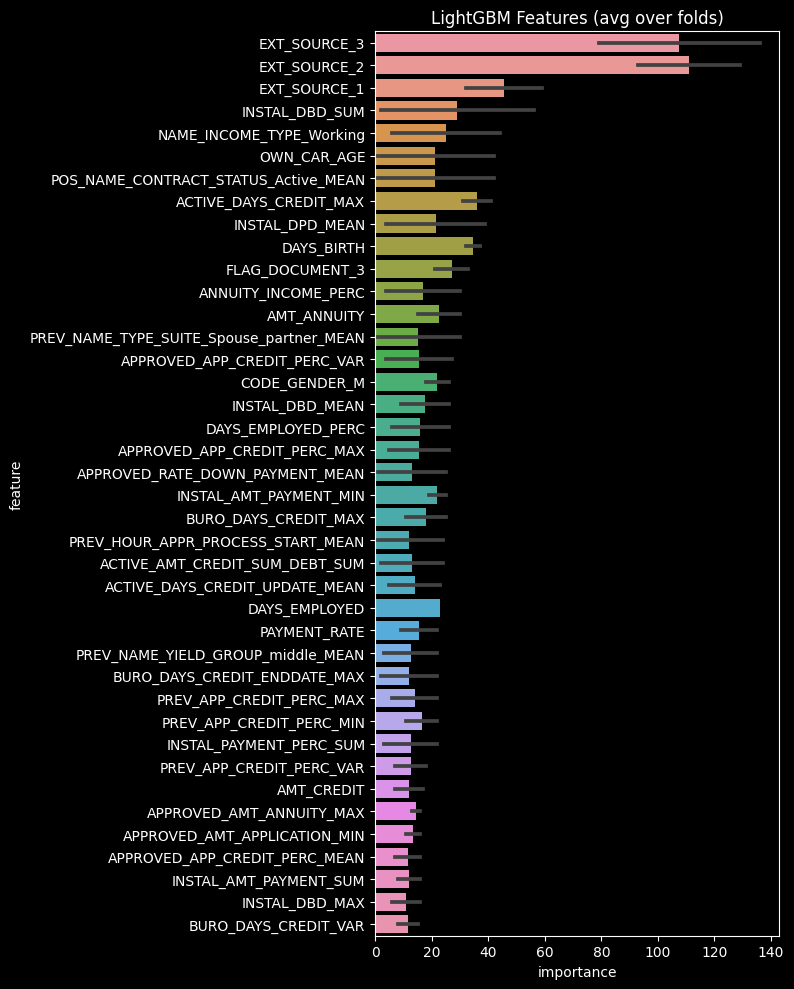

In [4]:
from home_credit.lightgbm_kernel import kfold_lightgbm
from pepper.feat_eng import nullify
data_sample = data.sample(10_000).copy()
nullify(data_sample.TARGET, -1)
feat_imp = kfold_lightgbm(data_sample, num_folds=2)

Et avec notre version révisée :

Starting LightGBM. Train shape: (8675, 788), test shape: (1325, 788)
[200]	training's auc: 0.868733	training's binary_logloss: 0.230133	valid_1's auc: 0.758283	valid_1's binary_logloss: 0.244646
[400]	training's auc: 0.919911	training's binary_logloss: 0.202039	valid_1's auc: 0.75671	valid_1's binary_logloss: 0.244374
Fold  1 AUC: 0.758615
[200]	training's auc: 0.862611	training's binary_logloss: 0.212892	valid_1's auc: 0.738822	valid_1's binary_logloss: 0.269135
[400]	training's auc: 0.912371	training's binary_logloss: 0.187891	valid_1's auc: 0.743284	valid_1's binary_logloss: 0.26776
Fold  2 AUC: 0.743496
Full AUC score: 0.745502


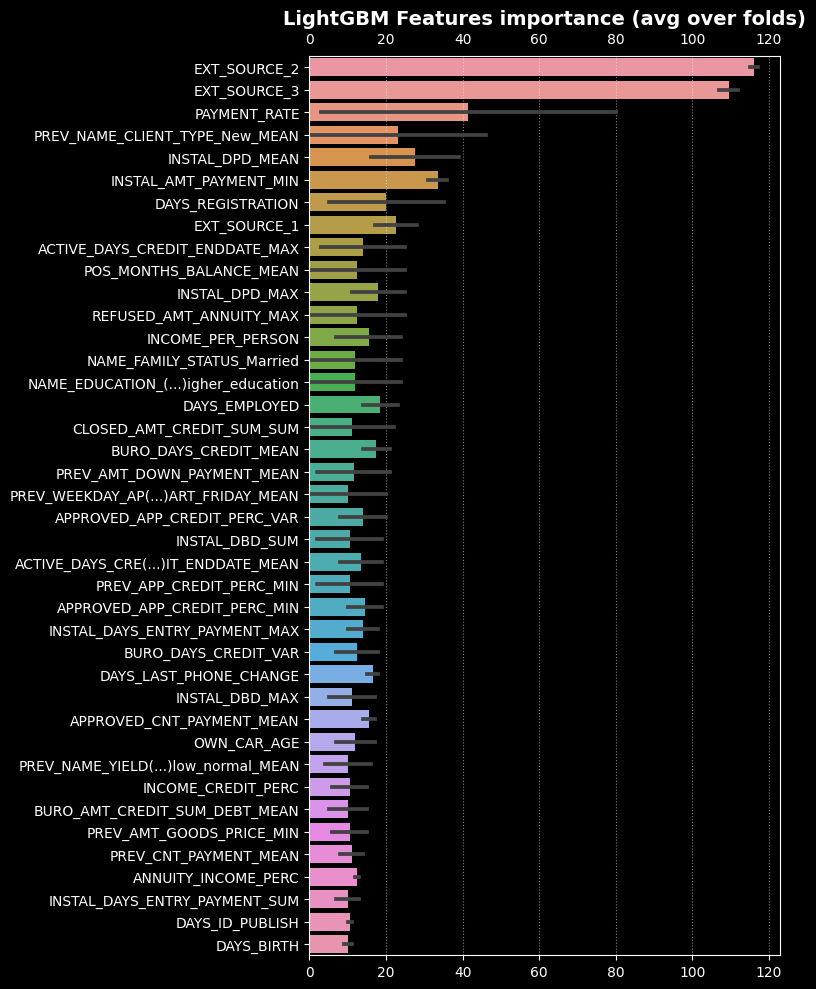

In [5]:
from home_credit.kernel import kfold_lightgbm
data_sample = data.sample(10_000).copy()  # Le copy est ici inutile, mais c'est pour l'équité avec la v1
feat_imp = kfold_lightgbm(data_sample, nfolds=2)

## `DISPLAY_IMPORTANCES`

Peu de modifications, sinon pour rendre le graphique plus lisible :
1. Rappel des graduations (d'abscisse, en haut de la figure) et affichage de la grille, légère, pour une meilleure visualisation de la largeur des barres au milieu du graphique.
2. Raccourcissement des étiquette de caractéristiques de longueur supérieur à 30, en remplaçant le milieu par `(...)`. Ainsi, l'information principale contenue généralement dans les préfixes et suffixes reste suffisante pour identifier la caractéristique, y compris si elle résulte un *one hot encoding*. Le graphique ne risque ainsi pas d'être ramassé, sur la droite, au profit de quelques étiquettes trop longues.


## `MAIN`

### Test de la version baseline 1

Paramètres par défaut : validation croisée avec ? plis ...

load C:\Users\franc\Projects\pepper_credit_scoring_tool\dataset\pqt\application_train.pqt
load C:\Users\franc\Projects\pepper_credit_scoring_tool\dataset\pqt\application_test.pqt
Preprocess `bureau` - Version 1
elapsed time: 22 s, 302 ms
Preprocess `previous_application` - Version 1
elapsed time: 29 s, 32 ms
Preprocess `pos_cash_balance` - Version 1
elapsed time: 15 s, 685 ms
Preprocess `credit_card_balance` - Version 1
elapsed time: 18 s, 147 ms
Preprocess `installments_payments` - Version 1
elapsed time: 35 s, 976 ms
Run LightGBM with kfold - Version 1
Starting LightGBM. Train shape: (307511, 788), test shape: (48744, 788)
[200]	training's auc: 0.796129	training's binary_logloss: 0.235405	valid_1's auc: 0.776406	valid_1's binary_logloss: 0.244073
[400]	training's auc: 0.819367	training's binary_logloss: 0.225688	valid_1's auc: 0.787153	valid_1's binary_logloss: 0.239587
[600]	training's auc: 0.834669	training's binary_logloss: 0.21945	valid_1's auc: 0.790221	valid_1's binary_logloss:

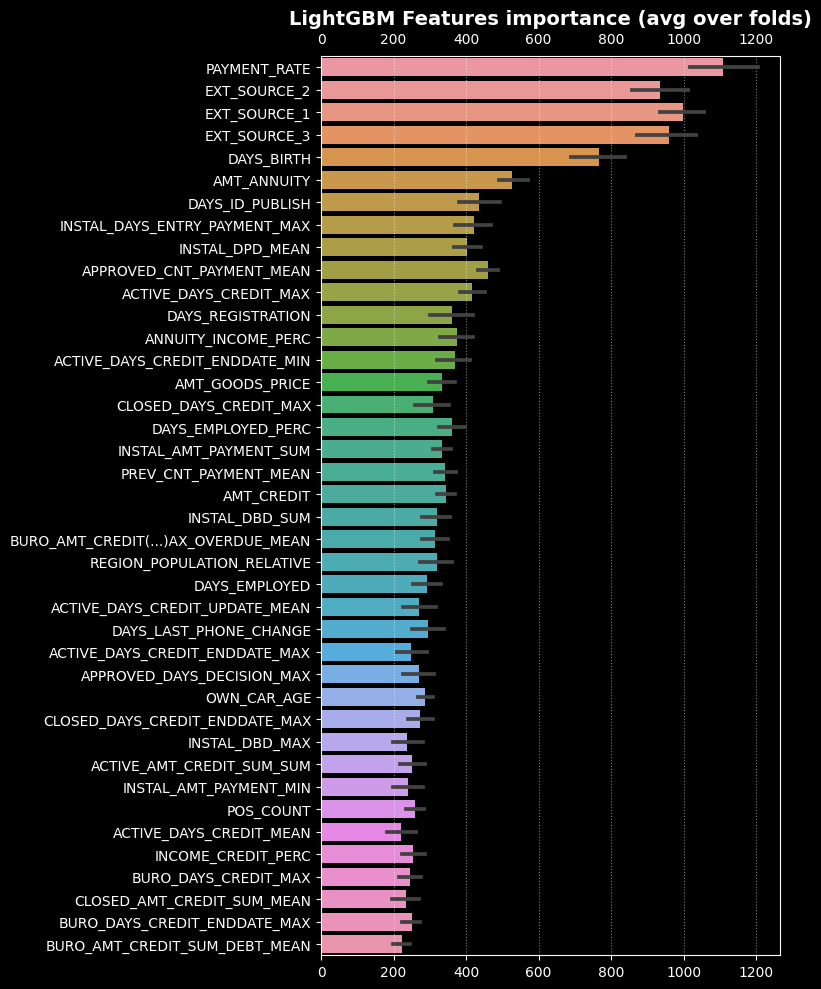

elapsed time: 1 h, 30 m


In [1]:
from home_credit.kernel import main as main_v2
main_v2(version=1, verbosity=1)

### Test de la version baseline 2

Preprocess `bureau` - Version 2
load C:\Users\franc\Projects\pepper_credit_scoring_tool\dataset\pqt\bureau.pqt
load C:\Users\franc\Projects\pepper_credit_scoring_tool\dataset\pqt\bureau_balance.pqt
elapsed time: 20 s, 615 ms
Preprocess `previous_application` - Version 2
load C:\Users\franc\Projects\pepper_credit_scoring_tool\dataset\pqt\previous_application.pqt
elapsed time: 23 s, 891 ms
Preprocess `pos_cash_balance` - Version 2
load C:\Users\franc\Projects\pepper_credit_scoring_tool\dataset\pqt\POS_CASH_balance.pqt
elapsed time: 10 s, 506 ms
Preprocess `credit_card_balance` - Version 2
load C:\Users\franc\Projects\pepper_credit_scoring_tool\dataset\pqt\credit_card_balance.pqt
elapsed time: 13 s, 733 ms
Preprocess `installments_payments` - Version 2
load C:\Users\franc\Projects\pepper_credit_scoring_tool\dataset\pqt\installments_payments.pqt
elapsed time: 12 s, 181 ms
Run LightGBM with kfold - Version 2
Starting LightGBM. Train shape: (307511, 788), test shape: (48744, 788)
[200]	train

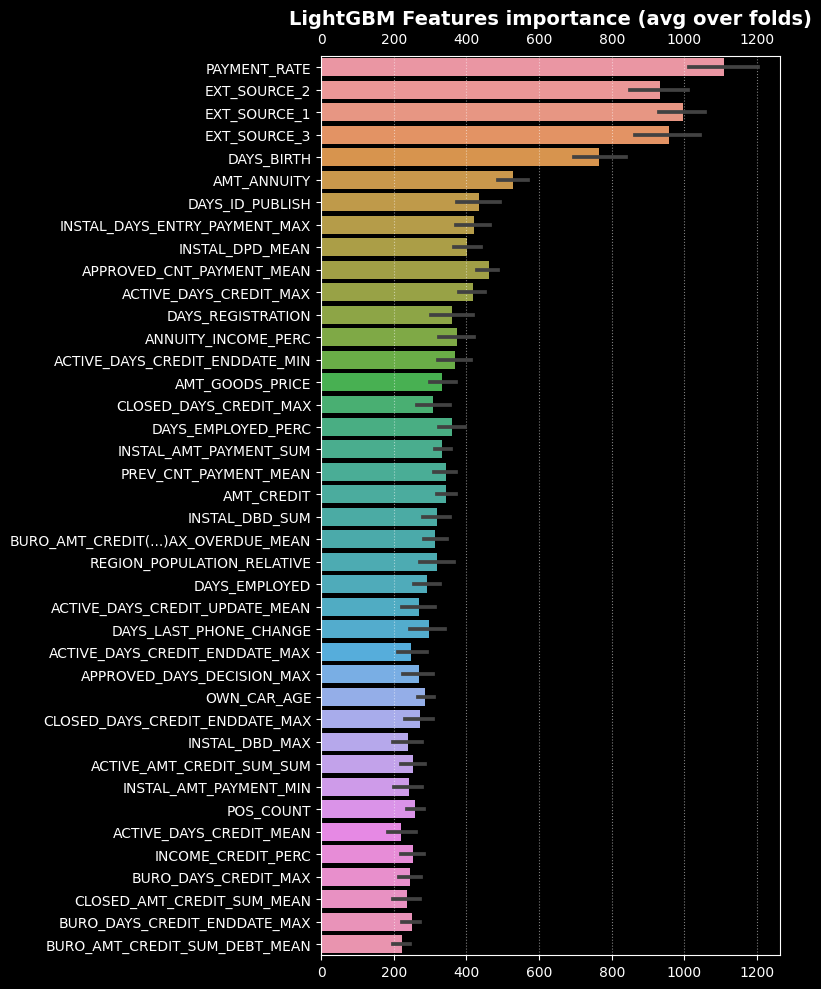

elapsed time: 1 h, 31 m


In [2]:
from home_credit.kernel import main as main_v2
main_v2(version=2, verbosity=1)

### Test de la version freestyle 1

Tirer parti de tous les potentiels d'amélioration que nous avons trouvés par l'anamyse exploratoire :
* drop_first, à quoi bon avoir 40 colonnes inutiles pour les 40 flags
* éliminer les données de mauvaise qualité (retrouver, c'est dans l'AE)
* correction et élimination plus ciblée d'outliers aberrants
* RLE, pour compresser sans perte d'information : innovant
* feature engineering plus intelligent :
    * les rapports (et non les produits) entre AMT, et entre CNT et AMT
    * les passages aux logs
    * discrétisation par quantiles de données numériques en longue traine (une alternative au log)
    * Fusion des classes rares
    * imputations des valeurs manquantes par défaut par la médiane (plus robuste vis à vis des outliers)
    * imputations plus intelligentes lorsque c'est possible
* et évidemment, mais c'est dans la modélisation, plus en aval, équilibrage des classes, 

# Annexes

Le but est de comprendre et d'améliorer techniquement la version de référence.

Nous progressons donc par petites étapes, à partir du chargement de la table.

## Comparaison des versions

Démonstration (qui a également servi aux tests et à la mise au point) des opérations pour comparer les versions d'origine et modifiée.

### Alignement

Les dataframes à comparer peuvent être égaux à une permutation près des lignes ou des colonnes.

L'utilitaire suivante permet de réaligner nos dataframes souvents triés et réindexés avec les versions brutes telles qu'elles sont chargées par le kernel d'origine.

In [ ]:
from pepper.pd_utils import align_df2_on_df1
from home_credit.old_kernel_v1 import load_A_table_v1
from home_credit.old_kernel_v2 import load_A_table_v2

app_v1 = load_A_table_v1()
app_v2 = align_df2_on_df1("SK_ID_CURR", app_v1, load_A_table_v2())
display(app_v1)
display(app_v2)

load C:\Users\franc\Projects\pepper_credit_scoring_tool\dataset\pqt\application_train.pqt
load C:\Users\franc\Projects\pepper_credit_scoring_tool\dataset\pqt\application_test.pqt


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,456221,NaN,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
356251,456222,NaN,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
356252,456223,NaN,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
356253,456224,NaN,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


application,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,456221,NaN,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
356251,456222,NaN,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
356252,456223,NaN,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
356253,456224,NaN,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


### Masque de comparaison

`pepper.pd_utils` contient deux fonctions `df_eq` et `df_neq` qui évitent le piège du `x == x` qui retourne `False` si `x` est NA. Ensuite, il faut utiliser `all` et `any` pour en tirer parti.

In [ ]:
from pepper.pd_utils import df_neq
is_diff = df_neq(app_v1, app_v2)
print("n_diffs:", is_diff.sum().sum())
print("n_diffs by cols:\n", is_diff.sum(), sep="")
print("n_diffs by rows:\n", is_diff.sum(axis=1), sep="")
display(is_diff.any())
display(is_diff.any(axis=1))

n_diffs: 0
n_diffs by cols:
SK_ID_CURR                    0
TARGET                        0
NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
                             ..
AMT_REQ_CREDIT_BUREAU_DAY     0
AMT_REQ_CREDIT_BUREAU_WEEK    0
AMT_REQ_CREDIT_BUREAU_MON     0
AMT_REQ_CREDIT_BUREAU_QRT     0
AMT_REQ_CREDIT_BUREAU_YEAR    0
Length: 122, dtype: int64
n_diffs by rows:
0         0
1         0
2         0
3         0
4         0
         ..
356250    0
356251    0
356252    0
356253    0
356254    0
Length: 356255, dtype: int64


SK_ID_CURR                    False
TARGET                        False
NAME_CONTRACT_TYPE            False
CODE_GENDER                   False
FLAG_OWN_CAR                  False
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     False
AMT_REQ_CREDIT_BUREAU_WEEK    False
AMT_REQ_CREDIT_BUREAU_MON     False
AMT_REQ_CREDIT_BUREAU_QRT     False
AMT_REQ_CREDIT_BUREAU_YEAR    False
Length: 122, dtype: bool

0         False
1         False
2         False
3         False
4         False
          ...  
356250    False
356251    False
356252    False
356253    False
356254    False
Length: 356255, dtype: bool

### Détection des variations locales de `dtype`

In [ ]:
from pepper.pd_utils import check_dtypes_alignment
check_dtypes_alignment(app_v1, app_v2)

dtypes are aligned


### Caculer la différence (la distance) entre les coefficients

In [ ]:
from pepper.pd_utils import safe_diff_series
display(safe_diff_series(app_v1.SK_ID_CURR, app_v2.SK_ID_CURR).sum())
display(safe_diff_series(app_v1.TARGET, app_v2.TARGET).sum())

0

0.0

In [ ]:
display(app_v1[is_diff.TARGET].TARGET)
display(app_v2[is_diff.TARGET].TARGET)

Series([], Name: TARGET, dtype: float64)

Series([], Name: TARGET, dtype: float64)

In [ ]:
from pepper.pd_utils import safe_diff_dataframe
diff = safe_diff_dataframe(app_v1, app_v2)

Ici, finition : en cas de diff, filtrer facilement des plages de la matrice des différences.

In [ ]:
display(diff.loc[is_diff.any(axis=1), is_diff.any()])

,TARGET,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,OWN_CAR_AGE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0.0,0.0,0.0,,NaN,,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,,NaN,,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,,0.0,,0.0,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,,NaN,,0.0,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,0.0,,NaN,,0.0,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,NaN,0.0,0.0,,NaN,,0.0,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
356251,NaN,0.0,0.0,,NaN,,0.0,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
356252,NaN,0.0,0.0,,0.0,,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
356253,NaN,0.0,0.0,,NaN,,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Hot encoding

Les tables `application_{train|test}` ont typiquement de nombreuses variables catégorielles.

Le critère choisi par la version de référence de `dtype == object` est discutable.

Nous aurons intérêt à encoder à chaud, par exemple, les variables binaires dont le `dtype` est `int`.

Les variables entières avec un nombre restreint de modalités auront également, pour nombre d'entre elles, intérêt à être considérées comme des catégories, y compris si elles représentent des cardinaux (nombre d'ascenseurs, nombre d'enfants par exemple), et pas seulement dans le cas des ordinaux (heure de la journée par exemple).

Notre amélioration va donc se concentrer sur la sélection des variables considérées comme catégorielles, avec une sélection par défaut isofonctionnelle au noyau de référence.

In [ ]:
import pandas as pd

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

### Sélection des variables catégorielles

In [ ]:
from home_credit.load import get_application_train
df = get_application_train()
display(df.head(3))

application_train,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
original_columns = list(df.columns)
categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
display(categorical_columns)

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [ ]:
from home_credit.kernel import get_categorical_vars
display(get_categorical_vars(df))
display(get_categorical_vars(df, dtype=None, max_modalities=2))

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

['TARGET',
 'NAME_CONTRACT_TYPE',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EMERGENCYSTATE_MODE',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21']

### Hot encoding avec `get_dummies`

Voir la documentation utilisateur de Pandas 2.0 : https://pandas.pydata.org/docs/user_guide/reshaping.html#reshaping-dummies

Elle illustre notamment l'utilisation conjointe avec `cut`.

`get_dummy` peut produire un tableau dense (par défaut) ou creux (voir https://pandas.pydata.org/docs/reference/api/pandas.arrays.SparseArray.html).

#### Comment ça marche ?

In [ ]:
import pandas as pd
a = df.CODE_GENDER
b = pd.get_dummies(a)
c = a.str.get_dummies()
display(pd.concat([a, b, c], axis=1).head(3))

,CODE_GENDER,F,M,XNA,F,M,XNA
0,M,False,True,False,0,1,0
1,F,True,False,False,1,0,0
2,M,False,True,False,0,1,0


In [ ]:
x = df[["NAME_CONTRACT_TYPE", "CODE_GENDER"]]
y = pd.get_dummies(x, dummy_na=True)
display(pd.concat([x, y], axis=1).head(3))

,NAME_CONTRACT_TYPE,CODE_GENDER,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_nan,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,CODE_GENDER_nan
0,Cash loans,M,True,False,False,False,True,False,False
1,Cash loans,F,True,False,False,True,False,False,False
2,Revolving loans,M,False,True,False,False,True,False,False


#### Le cas des NA

In [ ]:
# deux pb avec les NA :
# 1/ leur codage spécial => convertir en vrai NA
# 2/ si dummy_na=True mais qu'il n'y en a pas => une colonne pour rien
# la soluce : générer puis supprimer les constantes
display(a.value_counts(dropna=False))
display(y.CODE_GENDER_XNA.value_counts(dropna=False))
display(y.CODE_GENDER_nan.value_counts(dropna=False))

CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64

CODE_GENDER_XNA
False    307507
True          4
Name: count, dtype: int64

CODE_GENDER_nan
False    307511
Name: count, dtype: int64

#### Suppression des colonnes constantes (non NA)

In [ ]:
z = y.apply(pd.Series.nunique)
# Cette version générale est plus safe,
# mais celle qui précède est suffisante dans le contexte d'utilisation
# z = y.apply(lambda s: pd.Series.nunique(s, dropna=False))
print(list(z[z == 1].index))
truc = y.drop(columns=z[z == 1].index)
display(truc)

['NAME_CONTRACT_TYPE_nan', 'CODE_GENDER_nan']


,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA
0,True,False,False,True,False
1,True,False,True,False,False
2,False,True,False,True,False
3,True,False,True,False,False
4,True,False,False,True,False
...,...,...,...,...,...
307506,True,False,False,True,False
307507,True,False,True,False,False
307508,True,False,True,False,False
307509,True,False,True,False,False


#### Intérêt de `drop_first`

N'oublions pas que près de 20 % des variables sont binaires.

Souhaitons en faire 40 ou bien 80 colonnes ?

In [ ]:
# drop first : pertinent par exemple pour qu'une variable binaire ne donne pas deux colonnes
# ces deux colonnes seraient parfaitement anti-corrélées, donc corrélées
# logiquement, c'est l'un des premiers trucs qu'élimine une réduction de dimensionnalité
# le vérifier, en le conservant comme une option par défaut à True (à l'opposé de la valeur par défaut)
x = df[["NAME_CONTRACT_TYPE", "CODE_GENDER"]]
y = pd.get_dummies(x, dummy_na=True, drop_first=True)
display(pd.concat([x, y], axis=1).head(3))
m = y.memory_usage(deep=True)
print(m)
print(m.sum())

,NAME_CONTRACT_TYPE,CODE_GENDER,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_nan,CODE_GENDER_M,CODE_GENDER_XNA,CODE_GENDER_nan
0,Cash loans,M,False,False,True,False,False
1,Cash loans,F,False,False,False,False,False
2,Revolving loans,M,True,False,True,False,False


Index                                    128
NAME_CONTRACT_TYPE_Revolving loans    307511
NAME_CONTRACT_TYPE_nan                307511
CODE_GENDER_M                         307511
CODE_GENDER_XNA                       307511
CODE_GENDER_nan                       307511
dtype: int64
1537683


#### Question de l'empreinte mémoire

Faut-il des bools, des entiers int8, une matrice creuse, ... ?

In [ ]:
import numpy as np
x = df[["NAME_CONTRACT_TYPE", "CODE_GENDER"]]
y = pd.get_dummies(x, dummy_na=True, drop_first=True, dtype=np.int8)
display(pd.concat([x, y], axis=1).head(3))
m = y.memory_usage(deep=True)
print(m)
print(m.sum())

,NAME_CONTRACT_TYPE,CODE_GENDER,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_nan,CODE_GENDER_M,CODE_GENDER_XNA,CODE_GENDER_nan
0,Cash loans,M,0,0,1,0,0
1,Cash loans,F,0,0,0,0,0
2,Revolving loans,M,1,0,1,0,0


Index                                    128
NAME_CONTRACT_TYPE_Revolving loans    307511
NAME_CONTRACT_TYPE_nan                307511
CODE_GENDER_M                         307511
CODE_GENDER_XNA                       307511
CODE_GENDER_nan                       307511
dtype: int64
1537683


In [ ]:
import numpy as np
x = df[["NAME_CONTRACT_TYPE", "CODE_GENDER"]]
y = pd.get_dummies(x, dummy_na=True, drop_first=True, dtype=np.int8, sparse=True)
display(pd.concat([x, y], axis=1).head(3))
m = y.memory_usage(deep=True)
print(m)
print(m.sum())

,NAME_CONTRACT_TYPE,CODE_GENDER,NAME_CONTRACT_TYPE_Revolving loans,NAME_CONTRACT_TYPE_nan,CODE_GENDER_M,CODE_GENDER_XNA,CODE_GENDER_nan
0,Cash loans,M,0,0,1,0,0
1,Cash loans,F,0,0,0,0,0
2,Revolving loans,M,1,0,1,0,0


Index                                    128
NAME_CONTRACT_TYPE_Revolving loans    146395
NAME_CONTRACT_TYPE_nan                     0
CODE_GENDER_M                         525295
CODE_GENDER_XNA                           20
CODE_GENDER_nan                            0
dtype: int64
671838


#### Pourquoi ce nom inapproprié `get_dummies` ?

Echange avec chatGPT :

*Je me demandais pourquoi la fonction get_dummies de Pandas, qui effectue un hot encoding s'appelle comme elle s'appelle. En d'autres termes, quelle histoire à justifié ce nom éloigné de ce qu'elle fait ?*

En effet, le nom "get_dummies" de la fonction de Pandas peut sembler étrange et éloigné de l'encodage one-hot qu'elle effectue. La raison de ce nom remonte à l'origine de la fonctionnalité qui a été implémentée pour la première fois dans le langage de programmation R. Dans R, la fonction équivalente s'appelle "dummy variable", d'où le terme "dummies" dans le nom de la fonction de Pandas.

Le terme "dummy variable" a été introduit dans la théorie de la régression linéaire pour représenter des variables catégorielles qui ne peuvent pas être directement intégrées dans un modèle de régression linéaire. À la place, ces variables catégorielles sont remplacées par un ensemble de variables binaires qui indiquent la présence ou l'absence de chaque catégorie. Ces variables binaires sont souvent appelées "dummy variables", d'où le nom de la fonction dans R et, par extension, de la fonction de Pandas.

En résumé, le nom "get_dummies" de la fonction de Pandas est un héritage du nom de la fonction équivalente dans le langage R, qui lui-même fait référence aux variables binaires qui représentent les catégories dans un modèle de régression linéaire.

#### Version intégrée de `one_hot_encode_all_cats` :

**NB** Il reste, en amont dans les premiers prétraitements, à identifier les NA encodés maison par HomeCredit et à les convertir en vrais NA.

In [ ]:
def one_hot_encode_all_cats(
    df,
    columns=None,
    dummy_na=True,
    drop_first=True,
    dtype=np.int8,
    sparse=True
):
    ohe_df = pd.get_dummies(
        df, columns=columns, dummy_na=dummy_na,
        drop_first=drop_first, dtype=dtype, sparse=sparse
    )
    # Supression des colonnes constantes éventuellement produites par `dummy_na`
    const_cols = ohe_df.apply(pd.Series.nunique)
    const_cols = const_cols[const_cols == 1]
    ohe_df.drop(columns=const_cols.index, inplace=True)
    return ohe_df


ohe_df = one_hot_encode_all_cats(df[["NAME_CONTRACT_TYPE", "CODE_GENDER"]])
display(ohe_df)


,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,CODE_GENDER_XNA
0,0,1,0
1,0,0,0
2,1,1,0
3,0,0,0
4,0,1,0
...,...,...,...
307506,0,1,0
307507,0,0,0
307508,0,0,0
307509,0,0,0


## Caractéristiques dérivées : de l'intérêt de `eval`

L'ingénierie des caractéristiques a notamment pour objectif de produire des caractéristiques dérivées.

Dans ce contexte, `eval` permet un gain de lisibilité du code et de performance d'exécution.

[**Documentation d'utilisation de `pandas eval` pour améliorer les performances**](https://pandas.pydata.org/pandas-docs/stable/user_guide/enhancingperf.html#enhancingperf-eval).

### Comment ça marche ?

```python
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
```

In [ ]:
from home_credit.load import get_installments_payments
df = get_installments_payments()
display(df)

In [ ]:
import time

#amt_payment = df.AMT_PAYMENT
#amt_installment = df.AMT_INSTALMENT
t = -time.time()
df['PAYMENT_PERC'] = df['AMT_PAYMENT'] / df['AMT_INSTALMENT']
t += time.time()
print(t)

0.056481361389160156


In [ ]:
import time
import pandas as pd

t = -time.time()
#df['PAYMENT_PERC_2'] = df['AMT_PAYMENT'] / df['AMT_INSTALMENT']
df.eval("PAYMENT_PERC_2 = AMT_PAYMENT / AMT_INSTALMENT", inplace=True, engine="python")
t += time.time()
print(t)

0.16107678413391113


In [ ]:
import time
import pandas as pd

t = -time.time()
#df['PAYMENT_PERC_2'] = df['AMT_PAYMENT'] / df['AMT_INSTALMENT']
df.eval("PAYMENT_PERC_2 = AMT_PAYMENT / AMT_INSTALMENT", inplace=True, engine="numexpr")
t += time.time()
print(t)

0.13232922554016113


### Pandas assign : ce n'est pas une bonne alternative

In [ ]:
import time
import pandas as pd

t = -time.time()
#df['PAYMENT_PERC_2'] = df['AMT_PAYMENT'] / df['AMT_INSTALMENT']
df.assign(PAYMENT_PERC_3=df.AMT_PAYMENT / df.AMT_INSTALMENT)
t += time.time()
print(t)

0.8159232139587402


### Tout en une seule fois

#### Cf. kernel

In [ ]:
from home_credit.load import _load_installments_payments
import time

df_1 = _load_installments_payments()

t = -time.time()
# Percentage and difference paid in each installment (amount paid and installment value)
df_1['PAYMENT_PERC'] = df_1['AMT_PAYMENT'] / df_1['AMT_INSTALMENT']
df_1['PAYMENT_DIFF'] = df_1['AMT_INSTALMENT'] - df_1['AMT_PAYMENT']
# Days past due and days before due (no negative values)
df_1['DPD'] = df_1['DAYS_ENTRY_PAYMENT'] - df_1['DAYS_INSTALMENT']
df_1['DBD'] = df_1['DAYS_INSTALMENT'] - df_1['DAYS_ENTRY_PAYMENT']
df_1['DPD'] = df_1['DPD'].apply(lambda x: max(x, 0))
df_1['DBD'] = df_1['DBD'].apply(lambda x: max(x, 0))
t += time.time()
print(t)

load C:\Users\franc\Projects\pepper_credit_scoring_tool\dataset\pqt\installments_payments.pqt
7.973264455795288


#### Avec eval

In [ ]:
from home_credit.load import _load_installments_payments
from numpy import where
import time

df_2 = _load_installments_payments()

t = -time.time()
# ✔ Gain de lisibilité
# ✔ Gain de performance : un ordre de grandeur
df_2.eval(
    """
    PAYMENT_PERC = AMT_PAYMENT / AMT_INSTALMENT
    PAYMENT_DIFF = AMT_INSTALMENT - AMT_PAYMENT
    DPD = DAYS_ENTRY_PAYMENT - DAYS_INSTALMENT
    DBD = DAYS_INSTALMENT - DAYS_ENTRY_PAYMENT
    DPD = @where(DPD > 0, DPD, 0)
    DBD = @where(DBD > 0, DBD, 0)
    """,
    inplace=True, engine="numexpr"
)
t += time.time()
print(t)

load C:\Users\franc\Projects\pepper_credit_scoring_tool\dataset\pqt\installments_payments.pqt
0.6242649555206299


#### Compare dfs

In [ ]:
# display(df_1)
# display(df_2)
print("same result:", all(df_1 == df_2))

same result: True


## `del` et `gc.collect`

**TODO** faire une démonstration imparable de ce que j'avance ci-après :

Dans la plupart des fonctions, le dataframe de travail chargé puis modifié est explicitement supprimé de la mémoire à l'aide de `del` suivi d'un appel explicite au *garbage collector* à l'aide  de `gc.collect()`.

On peut voir là la marque d'un programmeur Java reconverti à Python.

Cependant, ces appels sont inutiles :
1. lorsque l'exécution de la fonction se termine, la variable locale est automatiquement librée (`del` implicite).
2. si le système a besoin de mémoire par exemple à l'étape suivante du préprocessing, le garbage collector sera alors appelé sans qu'il soit besoin d'une instruction explicite.

Nous décidons donc de ne pas conserver ces instructions.

## Groupby



### xxx Old, recycle : reverse engineering de l'agrégation de `bureau`

In [ ]:
from home_credit.load import get_bureau, get_bureau_balance
b = get_bureau()
bb = get_bureau_balance()

display(b.head(3))
display(bb.head(3))

bureau,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,0.0,0.0,Microloan,-19,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,0.0,0.0,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,NaN,0.0,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,0.0,0.0,Consumer credit,-1508,NaN


bureau_balance,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
...,...,...,...
27299920,5041336,-47,X
27299921,5041336,-48,X
27299922,5041336,-49,X
27299923,5041336,-50,X


In [ ]:
from home_credit.lightgbm_kernel import one_hot_encoder
bb, bb_cat = one_hot_encoder(bb, True)

# TODO : corriger
bureau, bureau_cat = one_hot_encoder(bureau, True)

In [ ]:
display(bb_cat)
display(bureau_cat)

['STATUS_0',
 'STATUS_1',
 'STATUS_2',
 'STATUS_3',
 'STATUS_4',
 'STATUS_5',
 'STATUS_C',
 'STATUS_X',
 'STATUS_nan']

['CREDIT_ACTIVE_Active',
 'CREDIT_ACTIVE_Bad debt',
 'CREDIT_ACTIVE_Closed',
 'CREDIT_ACTIVE_Sold',
 'CREDIT_ACTIVE_nan',
 'CREDIT_CURRENCY_currency 1',
 'CREDIT_CURRENCY_currency 2',
 'CREDIT_CURRENCY_currency 3',
 'CREDIT_CURRENCY_currency 4',
 'CREDIT_CURRENCY_nan',
 'CREDIT_TYPE_Another type of loan',
 'CREDIT_TYPE_Car loan',
 'CREDIT_TYPE_Cash loan (non-earmarked)',
 'CREDIT_TYPE_Consumer credit',
 'CREDIT_TYPE_Credit card',
 'CREDIT_TYPE_Interbank credit',
 'CREDIT_TYPE_Loan for business development',
 'CREDIT_TYPE_Loan for purchase of shares (margin lending)',
 'CREDIT_TYPE_Loan for the purchase of equipment',
 'CREDIT_TYPE_Loan for working capital replenishment',
 'CREDIT_TYPE_Microloan',
 'CREDIT_TYPE_Mobile operator loan',
 'CREDIT_TYPE_Mortgage',
 'CREDIT_TYPE_Real estate loan',
 'CREDIT_TYPE_Unknown type of loan',
 'CREDIT_TYPE_nan']

In [ ]:
# Bureau balance: Perform aggregations and merge with bureau.csv
bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
for col in bb_cat:
    bb_aggregations[col] = ['mean']

L'aggrégation des lignes de `bureau_balance` :
* moyenne de chaque catégorie de STATUS
* min, max, size de MONTHS_BALANCE

Je pense que l'on peut faire mieux cf. mon pivot...

conserver les deux pour pouvoir comparer 1/ les corrélations 2/ les performances finales

In [ ]:
display(bb_aggregations)

{'MONTHS_BALANCE': ['min', 'max', 'size'],
 'STATUS_0': ['mean'],
 'STATUS_1': ['mean'],
 'STATUS_2': ['mean'],
 'STATUS_3': ['mean'],
 'STATUS_4': ['mean'],
 'STATUS_5': ['mean'],
 'STATUS_C': ['mean'],
 'STATUS_X': ['mean'],
 'STATUS_nan': ['mean']}

In [ ]:
import pandas as pd
bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
# Reduction du multi-index produit par le groupby
bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])

In [ ]:
display(bb_agg)

,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_SIZE,STATUS_0_MEAN,STATUS_1_MEAN,STATUS_2_MEAN,STATUS_3_MEAN,STATUS_4_MEAN,STATUS_5_MEAN,STATUS_C_MEAN,STATUS_X_MEAN,STATUS_nan_MEAN
SK_ID_BUREAU,,,,,,,,,,,,
5001709,-96,0,97,0.000000,0.000000,0.0,0.0,0.0,0.0,0.886598,0.113402,0.0
5001710,-82,0,83,0.060241,0.000000,0.0,0.0,0.0,0.0,0.578313,0.361446,0.0
5001711,-3,0,4,0.750000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.250000,0.0
5001712,-18,0,19,0.526316,0.000000,0.0,0.0,0.0,0.0,0.473684,0.000000,0.0
5001713,-21,0,22,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6842884,-47,0,48,0.187500,0.000000,0.0,0.0,0.0,0.0,0.416667,0.395833,0.0
6842885,-23,0,24,0.500000,0.000000,0.0,0.0,0.0,0.5,0.000000,0.000000,0.0
6842886,-32,0,33,0.242424,0.000000,0.0,0.0,0.0,0.0,0.757576,0.000000,0.0


Ici, un simple concat serait plus adapté non ? tester

In [ ]:
bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)

In [ ]:
display(bureau.head(3))

,SK_ID_CURR,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_ACTIVE_nan,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_CURRENCY_nan,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Cash loan (non-earmarked),CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,CREDIT_TYPE_nan,MONTHS_BALANCE_MIN,MONTHS_BALANCE_MAX,MONTHS_BALANCE_SIZE,STATUS_0_MEAN,STATUS_1_MEAN,STATUS_2_MEAN,STATUS_3_MEAN,STATUS_4_MEAN,STATUS_5_MEAN,STATUS_C_MEAN,STATUS_X_MEAN,STATUS_nan_MEAN
0,215354,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,-131,NaN,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,215354,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,-20,NaN,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,215354,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,-16,NaN,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Pourquoi refaire une aggrégation sur `bureau` : parce que dans `bureau` `SK_ID_CURR` n'est pas une PK, il y a donc plusieurs lignes pour une demande (11 lignes en moyenne par demande).

Là, il y a du monde : le préalable est donc d'avoir terminé mon analyse exploratoire sur l'ensemble des colonnes de `bureau` pour bien comprendre ce que représente chacune des données.

Selon les cas, il choisit un ou plusieurs des ufuncs main, max, mean, sum, var : pourquoi ? comprendre sa logique et la dépasser si possible.

In [ ]:
# Bureau and bureau_balance numeric features
num_aggregations = {
    'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
    'DAYS_CREDIT_UPDATE': ['mean'],
    'CREDIT_DAY_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean'],
    'CNT_CREDIT_PROLONG': ['sum'],
    'MONTHS_BALANCE_MIN': ['min'],
    'MONTHS_BALANCE_MAX': ['max'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum']
}
cat_aggregations = {cat: ['mean'] for cat in bureau_cat}
for cat in bb_cat:
    cat_aggregations[f"{cat}_MEAN"] = ['mean']

In [ ]:
display(cat_aggregations)

{'CREDIT_ACTIVE_Active': ['mean'],
 'CREDIT_ACTIVE_Bad debt': ['mean'],
 'CREDIT_ACTIVE_Closed': ['mean'],
 'CREDIT_ACTIVE_Sold': ['mean'],
 'CREDIT_ACTIVE_nan': ['mean'],
 'CREDIT_CURRENCY_currency 1': ['mean'],
 'CREDIT_CURRENCY_currency 2': ['mean'],
 'CREDIT_CURRENCY_currency 3': ['mean'],
 'CREDIT_CURRENCY_currency 4': ['mean'],
 'CREDIT_CURRENCY_nan': ['mean'],
 'CREDIT_TYPE_Another type of loan': ['mean'],
 'CREDIT_TYPE_Car loan': ['mean'],
 'CREDIT_TYPE_Cash loan (non-earmarked)': ['mean'],
 'CREDIT_TYPE_Consumer credit': ['mean'],
 'CREDIT_TYPE_Credit card': ['mean'],
 'CREDIT_TYPE_Interbank credit': ['mean'],
 'CREDIT_TYPE_Loan for business development': ['mean'],
 'CREDIT_TYPE_Loan for purchase of shares (margin lending)': ['mean'],
 'CREDIT_TYPE_Loan for the purchase of equipment': ['mean'],
 'CREDIT_TYPE_Loan for working capital replenishment': ['mean'],
 'CREDIT_TYPE_Microloan': ['mean'],
 'CREDIT_TYPE_Mobile operator loan': ['mean'],
 'CREDIT_TYPE_Mortgage': ['mean'],
 '

Second niveau d'aggrégation, sur les variables numériques, et sur les catégorielles :

In [ ]:
bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
bureau_agg.columns = pd.Index(
    [f'BURO_{e[0]}_{e[1].upper()}' for e in bureau_agg.columns.tolist()]
)

In [ ]:
display(bureau_agg.head(3))

,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_MAX,BURO_AMT_CREDIT_SUM_MEAN,BURO_AMT_CREDIT_SUM_SUM,BURO_AMT_CREDIT_SUM_DEBT_MAX,BURO_AMT_CREDIT_SUM_DEBT_MEAN,BURO_AMT_CREDIT_SUM_DEBT_SUM,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_SUM,BURO_AMT_ANNUITY_MAX,BURO_AMT_ANNUITY_MEAN,BURO_CNT_CREDIT_PROLONG_SUM,BURO_MONTHS_BALANCE_MIN_MIN,BURO_MONTHS_BALANCE_MAX_MAX,BURO_MONTHS_BALANCE_SIZE_MEAN,BURO_MONTHS_BALANCE_SIZE_SUM,BURO_CREDIT_ACTIVE_Active_MEAN,BURO_CREDIT_ACTIVE_Bad debt_MEAN,BURO_CREDIT_ACTIVE_Closed_MEAN,BURO_CREDIT_ACTIVE_Sold_MEAN,BURO_CREDIT_ACTIVE_nan_MEAN,BURO_CREDIT_CURRENCY_currency 1_MEAN,BURO_CREDIT_CURRENCY_currency 2_MEAN,BURO_CREDIT_CURRENCY_currency 3_MEAN,BURO_CREDIT_CURRENCY_currency 4_MEAN,BURO_CREDIT_CURRENCY_nan_MEAN,BURO_CREDIT_TYPE_Another type of loan_MEAN,BURO_CREDIT_TYPE_Car loan_MEAN,BURO_CREDIT_TYPE_Cash loan (non-earmarked)_MEAN,BURO_CREDIT_TYPE_Consumer credit_MEAN,BURO_CREDIT_TYPE_Credit card_MEAN,BURO_CREDIT_TYPE_Interbank credit_MEAN,BURO_CREDIT_TYPE_Loan for business development_MEAN,BURO_CREDIT_TYPE_Loan for purchase of shares (margin lending)_MEAN,BURO_CREDIT_TYPE_Loan for the purchase of equipment_MEAN,BURO_CREDIT_TYPE_Loan for working capital replenishment_MEAN,BURO_CREDIT_TYPE_Microloan_MEAN,BURO_CREDIT_TYPE_Mobile operator loan_MEAN,BURO_CREDIT_TYPE_Mortgage_MEAN,BURO_CREDIT_TYPE_Real estate loan_MEAN,BURO_CREDIT_TYPE_Unknown type of loan_MEAN,BURO_CREDIT_TYPE_nan_MEAN,BURO_STATUS_0_MEAN_MEAN,BURO_STATUS_1_MEAN_MEAN,BURO_STATUS_2_MEAN_MEAN,BURO_STATUS_3_MEAN_MEAN,BURO_STATUS_4_MEAN_MEAN,BURO_STATUS_5_MEAN_MEAN,BURO_STATUS_C_MEAN_MEAN,BURO_STATUS_X_MEAN_MEAN,BURO_STATUS_nan_MEAN_MEAN
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,-1572,-49,-735.00,240043.666667,-1329.0,1778.0,82.428571,-93.142857,0,0.0,NaN,378000.0,207623.571429,1453365.000,373239.0,85240.928571,596686.5,0.0,0.00000,0.000,10822.5,3545.357143,0,-51.0,0.0,24.571429,172.0,0.428571,0.0,0.571429,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.336651,0.007519,0.0,0.0,0.0,0.0,0.441240,0.214590,0.0
100002,-1437,-103,-874.00,186150.000000,-1072.0,780.0,-349.000000,-499.875000,0,0.0,1681.029,450000.0,108131.945625,865055.565,245781.0,49156.200000,245781.0,0.0,7997.14125,31988.565,0.0,0.000000,0,-47.0,0.0,13.750000,110.0,0.250000,0.0,0.750000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.406960,0.255682,0.0,0.0,0.0,0.0,0.175426,0.161932,0.0
100003,-2586,-606,-1400.75,827783.583333,-2434.0,1216.0,-544.500000,-816.000000,0,0.0,0.000,810000.0,254350.125000,1017400.500,0.0,0.000000,0.0,0.0,202500.00000,810000.000,NaN,NaN,0,NaN,NaN,NaN,0.0,0.250000,0.0,0.750000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Mais ce n'est pas terminé, il complète avec une aggrégation spécifique, uniquement sur les variables numériques, et sur le sous-ensemble des deux catégories Active et Closed de la variable CREDIT_ACTIVE.

Là, je ne saisis pas ce qu'il fait..

Si j'entrevois : cela revient à agréger selon les deux axes SK_ID_CURR et CREDIT_ACTIVE puis pivoter CREDIT_ACTIVE en colonnes (et en ne conservant finalement que les deux catégories principales (Sold et bad debt évincés)). Pourtant ces deux catégories plus rares me semblent informatives : bad debt semble indiquer clairement un client qui a fait défaut (il n'y en a que 21) et Sold... difficile à anticiper la motivation, mais dans un monde de tritrisation, les mauvaises créances ont tendances à être celles que l'on cède.

In [ ]:
b = get_bureau()
display(b.head(3))
display(b.CREDIT_ACTIVE.value_counts())

bureau,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN


CREDIT_ACTIVE
Closed      1079273
Active       630607
Sold           6527
Bad debt         21
Name: count, dtype: int64